<a href="https://colab.research.google.com/github/semant/finance/blob/master/CPPI_Project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dynamic Hedging to Eliminate Shortfalls and Market Outperformance in Liability Driven Portfolios

> (c) Semant Jain, PhD. All Rights Reserved.

> semant@gmail.com


### Executive Summary
> Use of cutting-edge dynamic hedging strategies have enabled me to create a methodolgy to eliminate shortfalls and outperform the market for liability driven portfolios. Analysis of large cap, small cap, and all hedge fund strategies indicate all sectors and strategies exhibit fat tails, have negative skewness, and have had drawdowns as large as 80% numerous times over the course of the last century. Such large drawdowns would be catastrophic for any retirement or target date fund maturing in those years. To mitigate such occurances, naive strategies such as fixed allocation funds (e.g., 70% Equity and 30% Bonds) and target date funds (Starting at 80% Equity/20% Bonds and ending at 20% Equity/80% Bonds) are commonly used. My analysis shows that these funds only improve - but do not eliminate - expected shortfalls and require giving up on the market upside. The proposed strategy dynamically allocates risk budget between risky and risk free assets. Doing so enables maximizing market gains during low volatility periods and becomes defensive during high volatility periods. Not only does this strategy outperform fixed allocation and target date funds, in backtesting, the strategy outperformed the market in fourteen of the eighteen years between 2000 - 2018.


### Contents

+ **Historical perspective on markets**
     - Drawdowns: Large Cap v Small Cap
     - Tests of normality: Skewness, Kurtosis, Jarque Bera, Semideviation
     - Value at Risk


+ **Eliminating Idiosyncratic Risk**
    - Capital Asset Pricing Model
    - Failure of diversification
    - Hedging v. Insurance
    - Constant Proportion Portfolio Insurance


+ **Simulating Asset Returns**
    - Geometric Brownian Motion (GBM) dynamics simulation
    - Monte Carlo simulation of stocks using GBM
    - Portfolio simulation with max drawdown


+ **Asset Liability Management**
    - Historical perspective
    - Liability Driven Investing
    - Cox Ingersoll Ross (CIR) model to simulate interest rates
    - Monte Carlo Simulation of ZCB bonds using CIR
    - Monte Carlo Simulation of Asset Returns: Fixed Allocation
    - Distribution of Terminal Values and Measuring Risk Budget Efficiency
    - Evaluation of Glide Path Funds: Target Date Funds


+ **Dynamic Risk Budgeting**
    - Monte Carlo Simulation of Dynamic Risk Budgeting
    - Floor Allocator
    - Drawdown Allocator
    - Comparison of Max Drawdown
    - Market Outperformance: Historical Data Backtest
    
### Python libraries
The following libraries were used in the analysis:
+ Math
+ Matplotlib
+ Numpy
+ Pandas
+ Scipy
+ Seaborn

# Historical Perspective on Markets

### Introduction

Traditional investment strategies have segmented the market into large cap and small cap stocks. However, the analysis showed that both segments have had drawdowns exceeding 60% more than two dozen times between 1929 and 2018. These losses would be catastrophic for any liability driven investment strategy, such as a retirement fund. Evaluation of various hedge fund strategies have also indicated a non-normal distribution in returns with the frequent presence of fat tails. In the first section, large cap and small cap returns and drawdowns are evaluated. This is followed by evaluation of hedge fund strategies. Finally, time series analysis is carried out on risk adjusted returns for all the market sectors.

In [0]:
from IPython.display import display

import ipywidgets as widgets
import math
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import risk_kit as rk
import scipy as scipy
import scipy.stats as stats
import seaborn as sns


%matplotlib inline
%load_ext autoreload
%autoreload 2

In [0]:
me_m = pd.read_csv("data/Portfolios_Formed_on_ME_monthly_EW.csv", header=0, index_col=0, parse_dates=True, na_values=-99.99)
rets = me_m[['Lo 10', 'Hi 10']]
rets.columns = ['SmallCap', 'LargeCap']
rets = rets/100
rets.index = pd.to_datetime(rets.index, format="%Y%m")
rets.index = rets.index.to_period("M")

#### Large Cap
The following section analyzes large cap companies data from 1929 to 2018.
+ The first graph plots the overall index value. To account for the rise in index value over the decades, the returns have been plotted on a logarithmic scale.

$$ Return = \frac{Current - Baseline}{Baseline} $$

+ The next graph plots the drawdown. Drawdown measures the drop in current value from the most recent highest value.

$$ Drawdown = \frac{Current - Peak}{Peak} $$

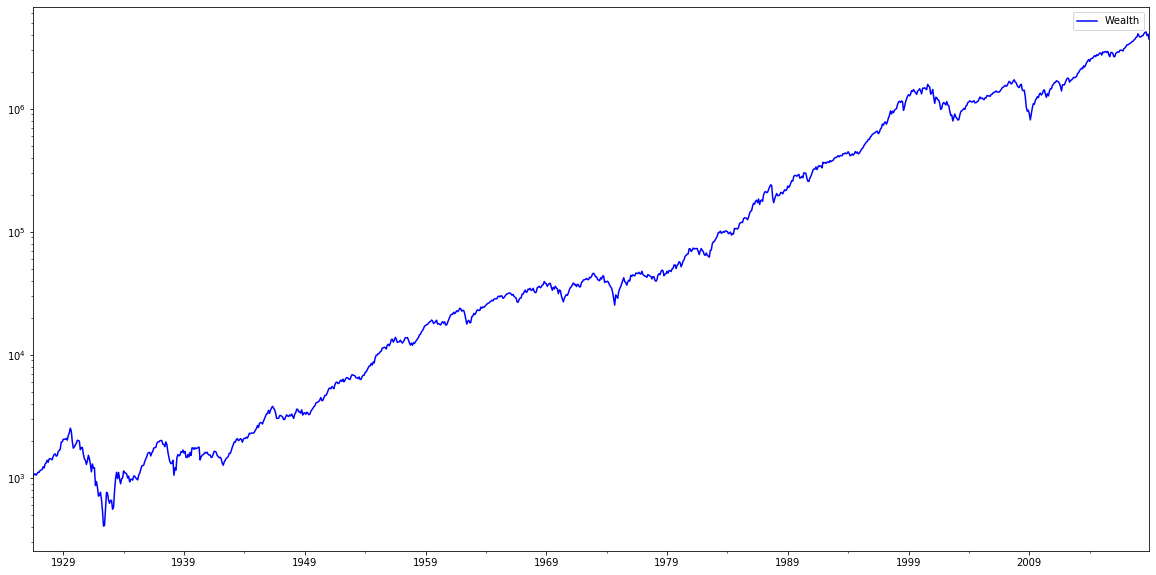

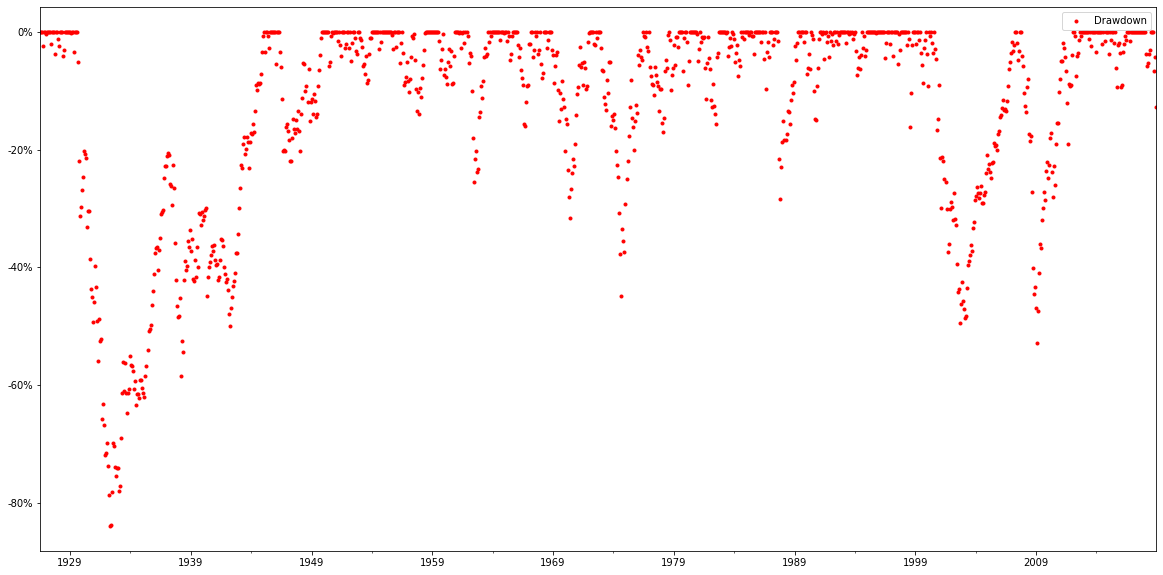

In [0]:
rk.drawdown(rets["LargeCap"])[["Wealth"]].plot(figsize=(20,10), style = 'b-').set_yscale('log')

yticks = mtick.FormatStrFormatter('%.0f%%')
(rk.drawdown(rets["LargeCap"])[["Drawdown"]]*100).plot(figsize=(20,10), style = 'r.').yaxis.set_major_formatter(yticks)

#### Small Cap
The following section analyzes small cap companies data from 1929 to 2018.

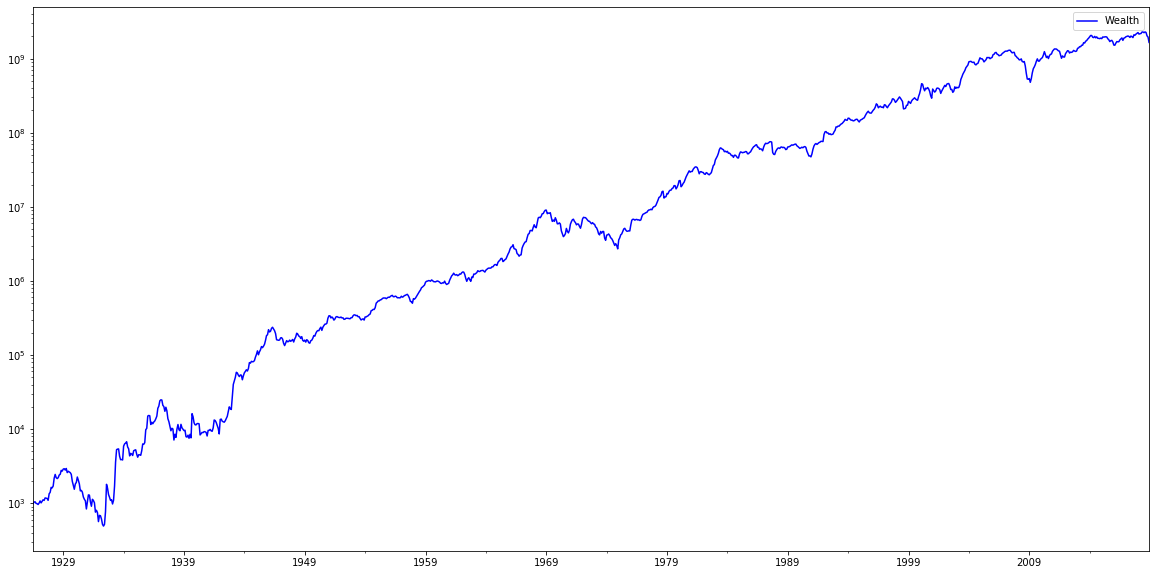

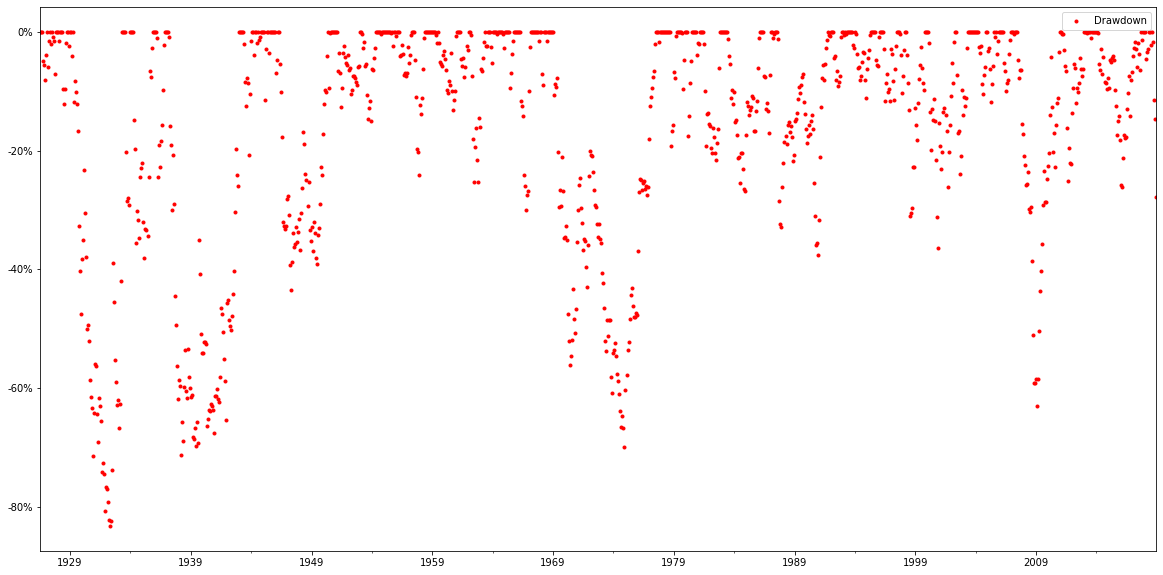

In [0]:
rk.drawdown(rets["SmallCap"])[["Wealth"]].plot(figsize=(20,10), style = 'b-').set_yscale('log')
(rk.drawdown(rets["SmallCap"])[["Drawdown"]]*100).plot(figsize=(20,10), style = 'r.').yaxis.set_major_formatter(yticks)

### Drawdown

#### Large Cap stocks

In [0]:
-rk.drawdown(rets["2000":]["LargeCap"])[["Drawdown"]].nsmallest(10, "Drawdown")*100

,Drawdown
2009-02,52.809450
2002-09,49.522821
2003-02,48.581034
2003-03,48.375358
2009-03,47.476918
2003-01,47.023526
2009-01,47.012632
2002-10,46.236757
2002-12,45.687437
2008-11,44.485248


In [0]:
ddL_min = rk.drawdown(rets["2000":]["LargeCap"])[["Drawdown"]].min()*100
ddL_avg = rk.drawdown(rets["2000":]["LargeCap"])[["Drawdown"]].mean()*100

ddL = [round(-ddL_min,2), round(-ddL_avg,2)]
ddL = pd.concat(ddL, axis=1)
ddL.columns = ['Worst', 'Avg']
ddL

,Worst,Avg
Drawdown,52.81,13.99


#### Small Cap stocks

In [0]:
-rk.drawdown(rets["2000":]["SmallCap"])[["Drawdown"]].nsmallest(10, "Drawdown")*100

,Drawdown
2009-02,63.120681
2008-12,59.243190
2008-11,59.165605
2009-03,58.580837
2009-01,58.529946
2008-10,51.096532
2009-04,50.408836
2009-05,43.614846
2009-06,40.316315
2008-09,38.555764


In [0]:
ddS_min = rk.drawdown(rets["2000":]["SmallCap"])[["Drawdown"]].min()*100
ddS_avg = rk.drawdown(rets["2000":]["SmallCap"])[["Drawdown"]].mean()*100

ddS = [round(-ddS_min,2), round(-ddS_avg,2)]
ddS = pd.concat(ddS, axis=1)
ddS.columns = ['Worst', 'Avg']
ddS

,Worst,Avg
Drawdown,63.12,10.97


As the above graphs demonstrated, under bearish market conditions of 1930, 1939, 1974, and 2009, the indexes suffered a drawdown of more than 60%. Such drawdowns are catastrophic for defined liability plans. Even after 2000, there were numerous months when the drawdown was more than 40% in large cap and small cap stocks. After 2000,
+ Large Cap stocks saw the worst and average drawdown of 52% and 14%
+ Small Cap stocks saw the worst and average drawdown of 63% and 11%

### Statistical Analysis on Distribution
+ **Skewness**

While a normal distribution is the most common assumption, data for hedge fund indices indicate that even professionally managed funds have a negative skewness
$$ S(R) = \frac{E[(R-E(R))^3]}{\sigma_R^3} $$

+ **Kurtosis**

Similarly, funds can also be shown to exhibit non-normal distribution through Kurtosis
$$ K(R) = \frac{E[(R-E(R))^4]}{\sigma_R^4} $$

Excess kurtosis is kurtosis over 3
$$ EK(R) = K(R) - 3 $$

+ **Jarque Bera test**

Testing for absence of fat tails

+ **Semi-deviation**

Semi-deviation measures the deviation below zero -- which is a more accurate representation of risk than oversall standard deviation. 

In [0]:
hfi = rk.get_hfi_returns()
s = pd.concat([round(hfi.mean(),4), round(hfi.median(),4), hfi.mean() > hfi.median(), round(rk.kurtosis(hfi)-3,1), hfi.aggregate(rk.is_normal), round(rk.semideviation(hfi),4)], axis = 'columns')
s.columns = ['Mean', 'Median', '+ Skew', 'E Kurtosis', 'Jarque Bera', 'Semi-deviation']
s

,Mean,Median,+ Skew,E Kurtosis,Jarque Bera,Semi-deviation
Convertible Arbitrage,0.0055,0.0065,False,20.3,False,0.0195
CTA Global,0.0041,0.0014,True,-0.0,True,0.0124
Distressed Securities,0.0069,0.0089,False,4.9,False,0.0152
Emerging Markets,0.0063,0.0096,False,6.3,False,0.0280
Equity Market Neutral,0.0045,0.0051,False,14.2,False,0.0096
Event Driven,0.0063,0.0084,False,5.0,False,0.0154
Fixed Income Arbitrage,0.0044,0.0055,False,26.8,False,0.0178
Global Macro,0.0054,0.0038,True,2.7,False,0.0066
Long/Short Equity,0.0063,0.0079,False,1.5,False,0.0141
Merger Arbitrage,0.0054,0.0060,False,5.7,False,0.0089


The above analysis shows that except CTA global, Global Macro, and Short Selling funds, all other funds had a negative skew. So, except for CTA Global, all other hedge funds exhibited excess kurtosis, i.e., non-normal behavior. Once again, all the funds except the CTA Global hedge funds show fat tails.

#### Summary statistics

In [0]:
ffme = rk.get_ffme_returns()
s = pd.concat([round(rk.skewness(ffme),2), round(rk.kurtosis(ffme)-3,2), ffme.aggregate(rk.is_normal)], axis = 'columns')
s.columns = ['Skew', 'Kurtosis', 'Is Normal']
s

,Skew,Kurtosis,Is Normal
SmallCap,4.41,43.85,False
LargeCap,0.23,7.69,False


#### Value at Risk (VaR)
There are 3 measures of Value at Risk:
+ **Parametric or Gaussian VaR**
Gaussian VaR is given by:

$$ z_{gaussian} = N (\frac{l}{100}) $$

$$ VaR_{gaussian} = - [ R_{mean} + z_{gaussian} {\sigma}] $$ 

where N is the normal distribution at the _l_th level (typically, _l_ = 5% entered as _l_ = 5), R_{mean} is the average of the returns, and {\sigma} is the standard deviation of the returns. As VaR is typically specified as a positive number, the negative is appended in the beginning.

+ **Modified Cornish Fisher VaR** accounts for skewess and kurtosis
The adjusted z-score - $z_{cornishfisher}$ - is given by:

$$ z_{Cornish Fisher} = z +\frac{1}{6}(z^2-1)S + \frac{1}{24}(z^3-3z)(K-3)-\frac{1}{36}(2z^3-5z)S^2 $$

$$ VaR_{Cornish Fisher} = - [ R_{mean} + z_{Cornish Fisher} {\sigma}] $$ 

+ **Historic VaR**
These calculations use historic data have been done using the standard 5% threshold (l = 5).

#### Conditional VaR (cVAR)
For the 5% of the cases that were below the VaR threshold, to measure the expected shortfall, the Conditional Historic VaR (cVaR) was computed. Being a spectral measure of risk, this is coherent measure of tail risk.

1.6879 3.8959 9.6821


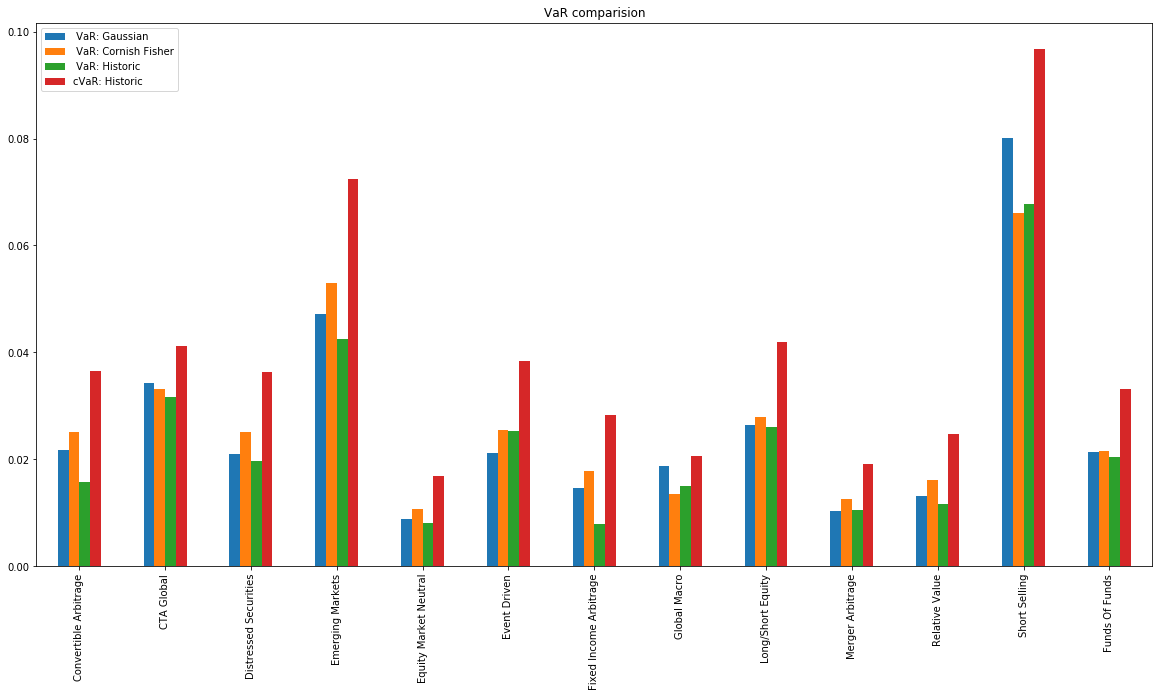

In [0]:
var_list = [rk.var_gaussian(hfi), rk.var_gaussian(hfi, modified = True), rk.var_historic(hfi), rk.cvar_historic(hfi)]
comparison = pd.concat(var_list, axis=1)
comparison.columns = [' VaR: Gaussian', ' VaR: Cornish Fisher', ' VaR: Historic', 'cVaR: Historic']
comparison.plot.bar(title = "VaR comparision", figsize=(20,10))
print(round(rk.cvar_historic(hfi).min()*100,4), round(rk.cvar_historic(hfi).mean()*100,4), round(rk.cvar_historic(hfi).max()*100,4))

Except for the CTA global and short selling funds, the modified Cornish Fisher VaR calculation has a higher VaR than the Gaussian VaR. The modified Cornish Fisher VaR is also higher than the historic VaR for all cases except the short selling funds. Thus, selecting the modified Cornish Fisher VaR would be a more conservative choice. For the 5% cases below the VaR threshold, cVaR indicated a shortfall ranging from 1.69% to 9.68% with an average shortfall of 3.90%.

---

# Risk Management

There are two components to risk management:
+ **Idosyncratic Risk**
which ensures that all the components of the portfolio maximize return per unit of risk through analysis of their correlations

+ **Systematic Risk**
Under extreme volatility or contagion conditions, correlations between different instruments tend to 1 eliminating the benefits of diversification. Under such conditions, a systematic portfolio hedging strategy is helpful.


### Idosyncratic Risk
This risk can be diversified away through the use of 
+ Capital Asset Pricing Model
+ Fama French Model

Here, we compute
+ Efficient Frontier
+ Tangency Portfolio
+ Global Minimum Variance Portfolio

In order to demonstrate the benefits and limitations of CAPM, synthetic data was constructed for the various industry sectors.

#### Sector Wise Sharpe Ratio
Sharpe ratio measures the excess portfolio return over the risk free rate per unit of standard deviation over the measurement period.

$$ SharpeRatio = \frac{R_{Portfolio} - R_{RiskFreeRate}}{\sigma} $$

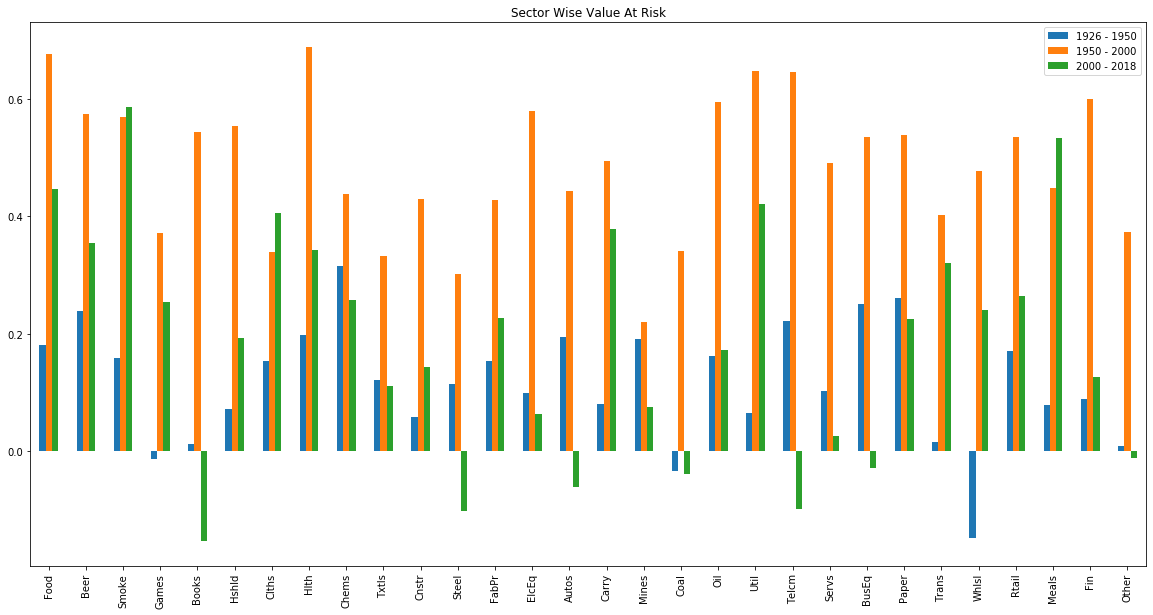

In [0]:
ind = pd.read_csv("data/ind30_m_vw_rets.csv", header = 0, index_col = 0, parse_dates = True)/100
ind.index = pd.to_datetime(ind.index, format ="%Y%m").to_period("M")
ind.columns = ind.columns.str.strip()
ind = rk.get_ind_returns()

sr0 = rk.sharpe_ratio(ind["1926":"1950"], 0.03, 12)
sr1 = rk.sharpe_ratio(ind["1950":"2000"], 0.03, 12)
sr2 = rk.sharpe_ratio(ind["2000":], 0.03, 12)
sr012 = pd.concat([sr0, sr1, sr2], axis=1)
sr012.plot.bar(title = "Sector Wise Value At Risk", figsize=(20,10)).legend(["1926 - 1950", "1950 - 2000", "2000 - 2018"])

# Capital Asset Pricing Model (CAPM)

Capital Asset Pricing Model (CAPM) is a single parameter model that assumes that the excess return of an instrument over the market's risk adjusted rate can be attributed to its correlation with the market's return.

$$ R_{Stock} - R_{RiskFreeRate} = \beta(R_{Market} - R_{RiskFreeRae}) $$



### Efficient Frontier (EF)
**Introduction**

If two assets are not perfectly correlated, then, combining them in the portfolio reduces the overall portfolio volatility. This reduction in idiosyncratic risk improves the portfolio's risk adjusted returns. The highest portfolio's returns over a range of volatility is the portfolio's efficient frontier.

**Maximum Sharpe Ratio (MSR) or Tangency Portfolio**

From the above analyzed industry sectors, an efficient frontier can be constructed using N-assets. In this analysis, four sectors - Smoke, Finance, Games, and Coal - were included.

A completely risk free asset - such as a principal protected bond - permits the construction of a Capital Market Line (CML). The intersection of the CML and the EF is the Maximum Sharpe Ratio (MSR) or the tangency portfolio - which maximizes the sharpe ratio and contains no exposure to unrewarded risks.

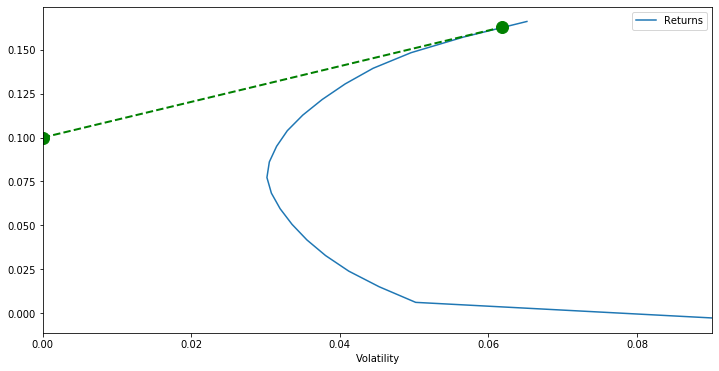

In [0]:
ind = rk.get_ind_returns()
er  = rk.annualize_rets(ind["2000":], 12)
cov = ind["2000":].cov()
l = ["Smoke", "Fin", "Games", "Coal"]
rk.plot_ef(20, er, cov, style='-', show_cml=True, riskfree_rate=0.1)

### Global Minimum Variance (GMV) portfolio
**Lack of robustness of Markowitz procedure**

The simplicity of the CAPM belies the accuracy required to estimate the expected asset class returns. Even modest variation in their estimate leads to drastic changes in portfolio allocation to these sector. This makes the porfolio allocation inherently unstable.

In [0]:
# Investment weights in each sector
ind = rk.get_ind_returns()
er = rk.annualize_rets(ind["2000":], 12)
cov = ind["2000":].cov()
l = ["Smoke", "Fin", "Games", "Coal"]
w1 = rk.msr(0.1, np.array(er[l]), cov.loc[l,l])
r1 = er[l]

# Making 2% changes to the expected returns
r2 = [r1[0]-0.02, r1[1]+0.02, r1[2]+0.02, r1[3]+0.02]
w2 = rk.msr(0.1, np.array(r2), cov.loc[l,l])

# Comparing the weights
data = {'Original':[round(w1[0]*100,2), round(w1[1]*100,2), round(w1[2]*100,2), round(w1[3]*100,2)], 'Modified':[round(w2[0]*100,2), round(w2[1]*100,2), round(w2[2]*100,2), round(w2[3]*100,2)]} 
df = pd.DataFrame(data, index =['Smoke', 'Finance', 'Games', 'Beer']) 
df.name = 'Change in weights'
print (df.name)
df

Change in weights


,Original,Modified
Smoke,100.0,93.0
Finance,0.0,0.0
Games,0.0,7.0
Beer,0.0,0.0


As the above analysis shows, CAPM is very sensitive to the estimated weights. As smoke had 16.6% annual returns, in the original portfolio, it allocated 100% of assets to smoke. Then, just +/- 2% variation in the expected returns causes a 7% allocation change from Smoke to  Games. As Finance and Coal industries have the third and fourth highest returns, they are allocated nothing.

**Equally Weighted (EW) & Global Minimum Variance (GMV) Portfolios**

The simplest way to eliminate the sensitivity of asset allocation to estimated returns is to allocate capital to all assets equally. However, doing so results in a portfolio far inside the efficient frontier (shown as the yellow dot in the figure). In order to minimize volatility for the same returns, another portfolio -- which is on the nose of the efficient frontier -- can be selected. This is the Global Minimum Variance (GMV) portfolio (shown as blue dot).

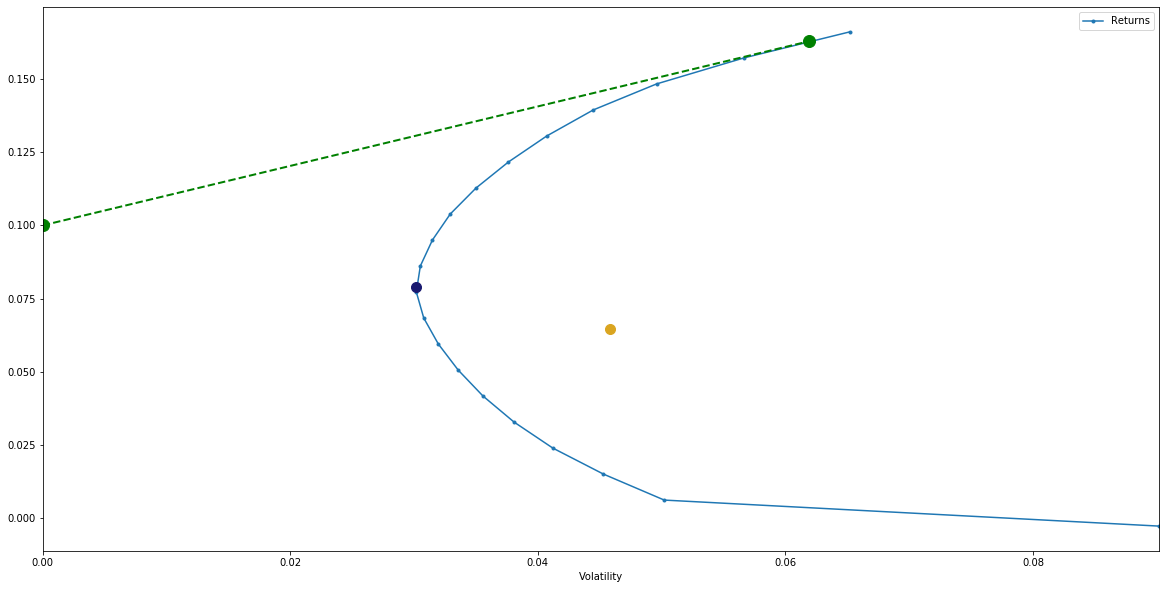

In [0]:
rk.plot_ef(20, er, cov, show_cml=True, riskfree_rate=0.1, show_ew=True, show_gmv=True, figsize=(20,10))

### Covariance and Market Returns: Negative correlation
The key principle that underpins portfolio diversification is the improvement in portfolio variance on account of individual asset volatility. However, during market crashes, the covariance between individual assets increase which negates the point of diversification. This can be show by analyzing the trailing 3 year returns with the average correlation between asset classes. A numerical analysis also shows a correlation of -28%. Thus, the very moment when diversification is most needed -- during market crashes --  it fails.

-28.01

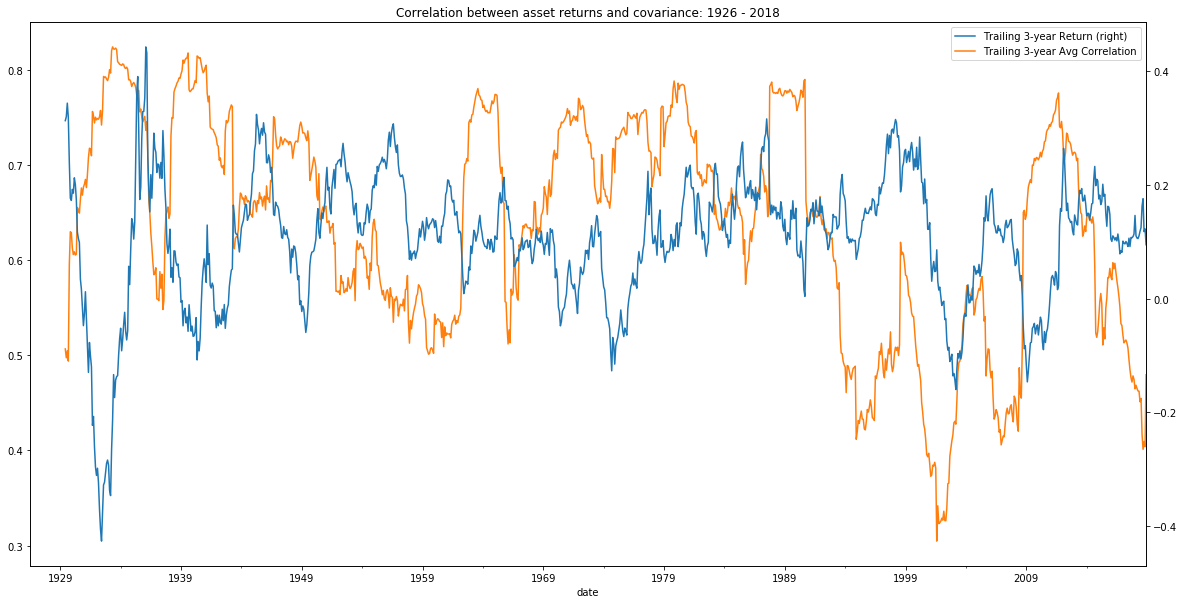

In [0]:
ind_return = rk.get_ind_returns()
ts_corr = ind_return.rolling(window=36).corr()
total_market_return = rk.get_total_market_index_returns()
tmi_tr36rets = total_market_return.rolling(window=36).aggregate(rk.annualize_rets, periods_per_year=12)
ts_corr.index.names = ['date', 'industry']
ind_tr36corr = ts_corr.groupby(level='date').apply(lambda cormat: cormat.values.mean())
tmi_tr36rets.plot(secondary_y=True, legend=True, label="Trailing 3-year Return", figsize=(20,10))
ind_tr36corr.plot(legend=True, label="Trailing 3-year Avg Correlation", title = "Correlation between asset returns and covariance: 1926 - 2018")

# Correlation between market return and asset covariance
round(tmi_tr36rets.corr(ind_tr36corr)*100,2)

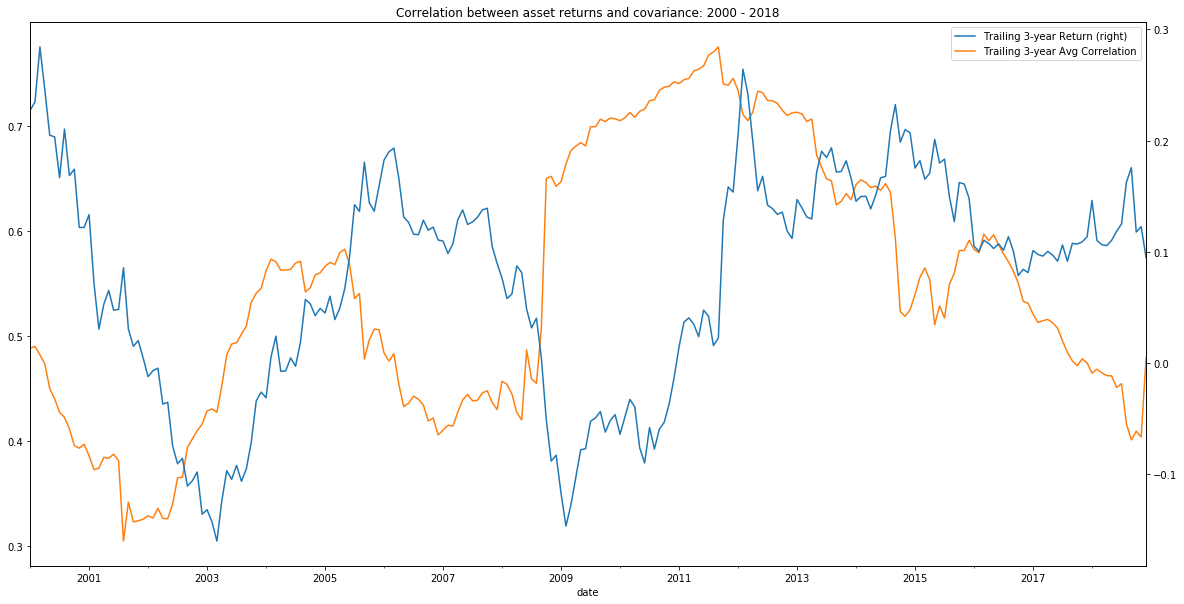

In [0]:
tmi_tr36rets["2000":].plot(secondary_y=True, legend=True, label="Trailing 3-year Return", figsize=(20,10))
ind_tr36corr["2000":].plot(legend=True, label="Trailing 3-year Avg Correlation", title = "Correlation between asset returns and covariance: 2000 - 2018")

### Conclusion
Thus, use of the Global Minimum Variance (GMV) portfolio eliminates all idosycratic risk by maximizing portfolio returns per unit of volatility. By only relying on the more stable variance calculations of the individual assets, this approach results in a more stable capital allocation between the various assets. As much as this approach maximizes benefits of diversification, this approach can not account for systemic risk. Market returns and covariance between asset classes have been shown to have a negative correlation. So, during market crashes, the increase in correlation between asset classes negates the benefits of diversification.

---

# Portfolio Hedging Strategies

### Hedging
Traditional hedging strategies give up on the upside returns to obtain downside protection. Furthermore, hedging can not help manage systemic risk. On the other hand, insurance -- is dynamic hedging -- which permits downside protection while allowing for upside potential. 

### Constant Proportion Portfolio Insurance (CPPI)

Constant Proportion Portfolio Insurance (CPPI) strategies dynamically allocate a fraction of the assets between risk free and risky assets.
+ F = 0.8: Means that the investors are willing to lose no more than 80% of the principal in the investment strategies.
+ M = 3: Is the capital leveraging factor. This means that upto 3 x (1 - F) = 60% of the capital can be initially invested in risky assets.
+ C: Is the cushion between the current valuation of the portfolio and the floor.

<img src="Project-CPPI.png">

Infrequent rebalancing of portfolios can lead to Gap Risk - a loss in the portfolio relative to the safe portfolio - which exceeds the set threshold. One way to alleviate this concern is through the use of maximum drawdown constraints which keeps a track of the portfolio peak at any given point in time.

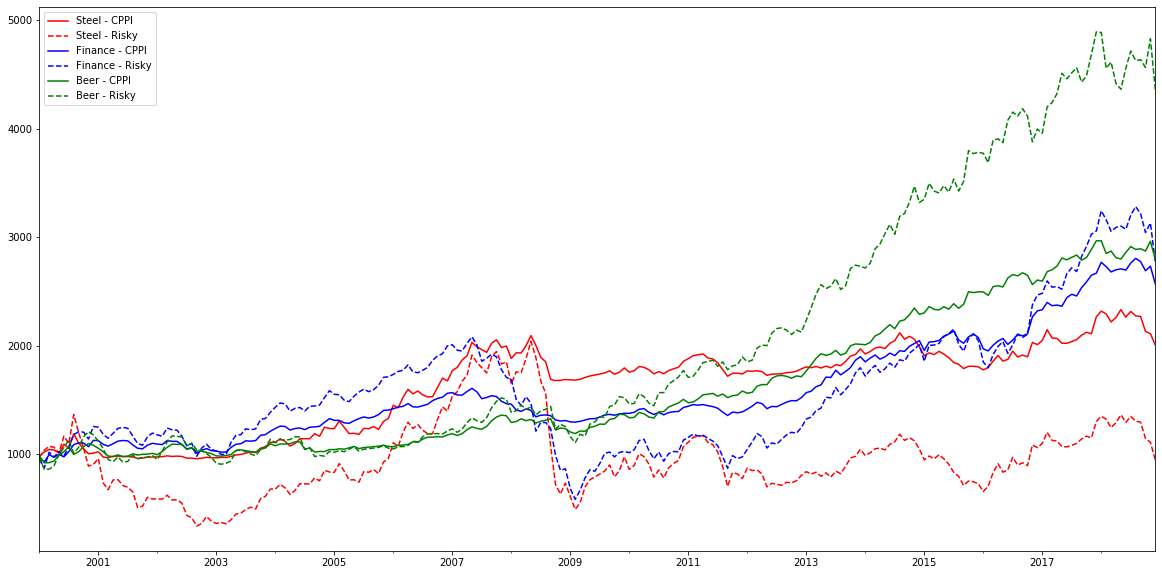

In [0]:
btr = rk.run_cppi(ind_return["2000":][["Steel", "Fin", "Beer"]], drawdown = 0.20)

ax2 = btr["Wealth"]["Steel"].plot(figsize = (20,10), style = 'r', legend=True, label = "Steel - CPPI")
btr["Risky Wealth"]["Steel"].plot(ax=ax2, style="r--", legend=True, label = "Steel - Risky")

btr["Wealth"]["Fin"].plot(ax=ax2, style="b", legend=True, label = "Finance - CPPI")
btr["Risky Wealth"]["Fin"].plot(ax=ax2, style="b--", legend=True, label = "Finance - Risky")

btr["Wealth"]["Beer"].plot(ax=ax2, style="g", legend=True, label = "Beer - CPPI")
btr["Risky Wealth"]["Beer"].plot(ax=ax2, style="g--", legend=True, label = "Beer - Risky")

In [0]:
r1 = rk.summary_stats(btr["Risky Wealth"].pct_change().dropna())
r2 = rk.summary_stats(btr["Wealth"].pct_change().dropna())
r12 = pd.concat([r1, r2], axis=0)
r12

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher Var (5%),Sharpe Ratio,Max Drawdown
Steel,-0.001320,0.312973,-0.330333,4.132666,0.208117,-0.097801,-0.758017
Fin,0.057941,0.192986,-0.543630,5.015294,0.132175,0.140661,-0.718465
Beer,0.082286,0.139058,-0.502368,4.181533,0.091442,0.365788,-0.271368
Steel,0.038389,0.097127,0.494924,5.187552,0.054438,0.083941,-0.197943
Fin,0.052602,0.073573,-0.088573,3.768008,0.042077,0.298912,-0.193668
Beer,0.056568,0.072510,-0.746848,4.576511,0.048819,0.356528,-0.125096


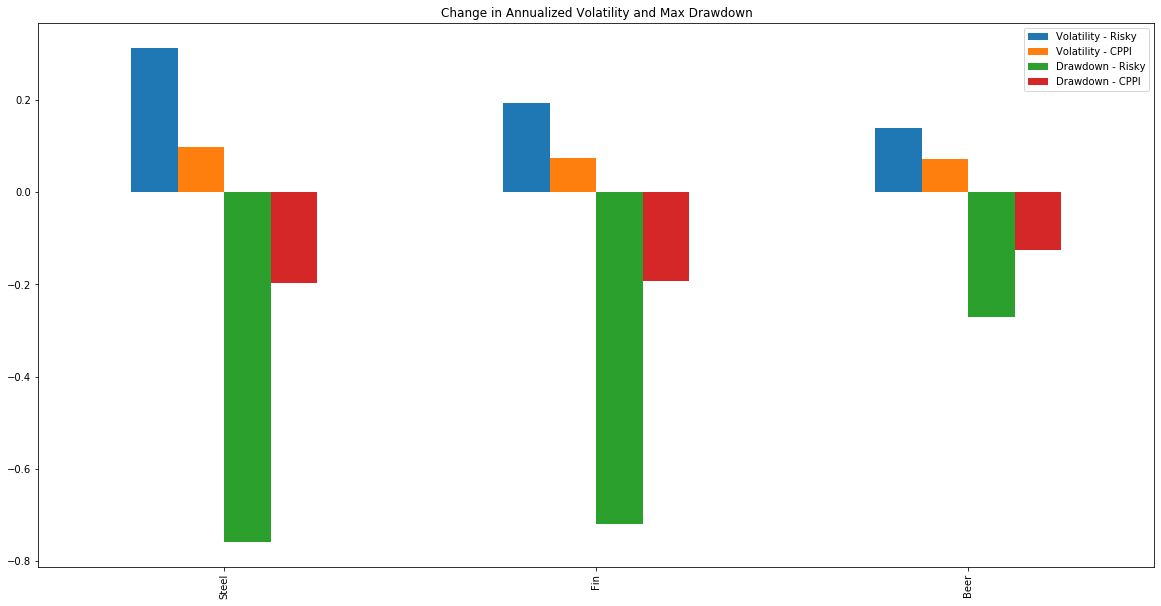

In [0]:
r12b = pd.concat([r1, r2], axis=1)
r12b[["Annualized Vol", "Max Drawdown"]].plot.bar(title = "Change in Annualized Volatility and Max Drawdown", figsize=(20,10)).legend(["Volatility - Risky", "Volatility - CPPI", "Drawdown - Risky", "Drawdown - CPPI"])

In [0]:
# Fractional change in volatility and sharpe ratio
dV21_s = 1 - r2["Annualized Vol"]["Steel"]/r1["Annualized Vol"]["Steel"]
dV21_f = 1 - r2["Annualized Vol"]["Fin"]/r1["Annualized Vol"]["Fin"]
dV21_b = 1 - r2["Annualized Vol"]["Beer"]/r1["Annualized Vol"]["Beer"]

dD21_s = 1 - r2["Max Drawdown"]["Steel"]/r1["Max Drawdown"]["Steel"]
dD21_f = 1 - r2["Max Drawdown"]["Fin"]/r1["Max Drawdown"]["Fin"]
dD21_b = 1 - r2["Max Drawdown"]["Beer"]/r1["Max Drawdown"]["Beer"]
  
# Create the pandas DataFrame 
data = {'Reduction in Annualized Volatility':[round(dV21_s*100,2), round(dV21_f*100,2), round(dV21_b*100,2)], 'Reduction in Max Drawdown':[round(dD21_s*100,2), round(dD21_f*100,2), round(dD21_b*100,2)]} 
df = pd.DataFrame(data, index =['Steel', 'Finance', 'Beer']) 
df

,Reduction in Annualized Volatility,Reduction in Max Drawdown
Steel,68.97,73.89
Finance,61.88,73.04
Beer,47.86,53.90


In this CPPI analysis, by setting a drawdown of 20%, leads to a significant improvement in the downside risk for all three sectors by reducing the annualized volatility by 48% to as much as 70%. Similarly, the maximum drawdown also gets reduced by 50% to as much as 73%. Thus, setting a maximum drawdown constraint can save a liability driven portfolio from catastrophic losses. 

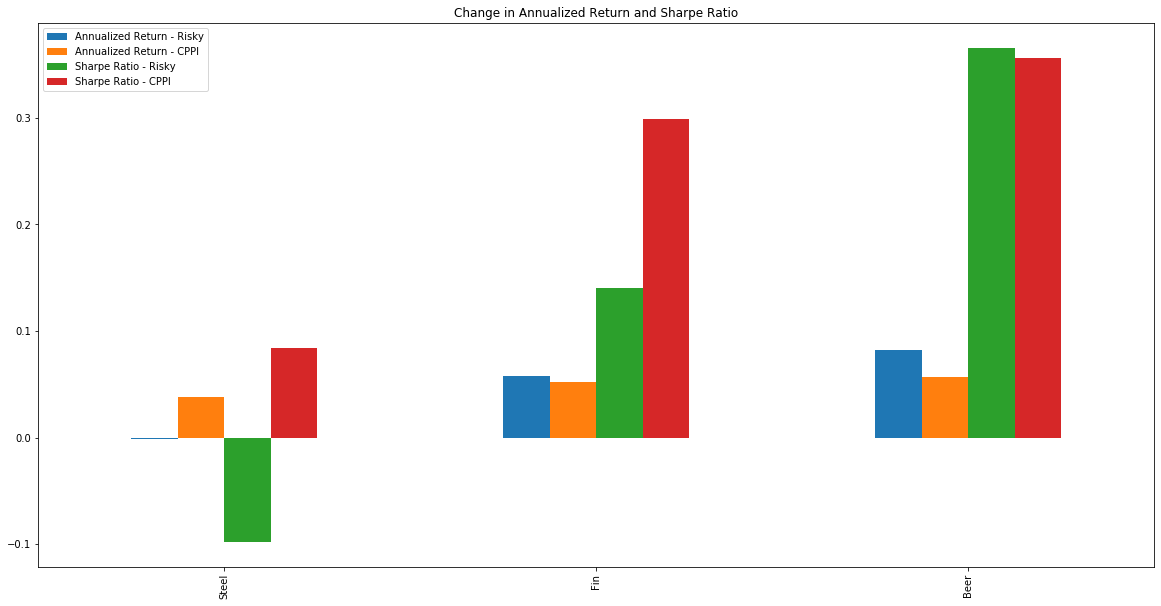

In [0]:
r12b[["Annualized Return", "Sharpe Ratio"]].plot.bar(title = "Change in Annualized Return and Sharpe Ratio", figsize=(20,10)).legend(["Annualized Return - Risky", "Annualized Return - CPPI", "Sharpe Ratio - Risky", "Sharpe Ratio - CPPI"])

Similar analysis on annualized return and sharpe ratio indicates a performance improvement for both steel and finance. However, a performance drop is seen in the beer sector.

# Simulating Asset Returns

Asset returns are often assumed to follow a random walk, i.e., they are zero serial correlation and a variance proportional to time. Thus, this can be modeled using the Brownian Motion Process with time varying parameters.

### Geomtric Brownian Motion (GBM)

Brownian motion for asset returns can be modeled as 

$$ \frac{S_{t+dt}-S_t}{S_t} = (r + \sigma \lambda)  dt + \sigma\sqrt{dt}\xi_t $$

where $\mu = r + \sigma \lambda$ is the mean, $\sigma$ is the annualized volatility, $\sigma\sqrt{dt}$ is the variance, and $\xi_t $ is a random Brownian motion. This can be used to construct a more general case:

$$ \frac{S_{t+dt}-S_t}{S_t} = [r(t) + \sigma(t) \lambda(t) ] dt + \sigma(t) \sqrt{dt}\xi_t $$


### Monte Carlo Simulation of Stocks

Monte Carlo simulation can be carried out with the following set of parameters:
+ Number of scenarios: 100
+ mu (average return): 7%
+ m (capital leverage factor): 3
+ floor (minimum acceptable return): 80%
+ riskfree_rate (U.S. treasuries): 3%
+ y_max (y-axis magnification): 100%

The following parameters were varied:
+ Sigma (average annual volatility: Varied from 15% to 35%
+ steps_per_year (number of annual portfolio rebalances) = Varied from 4 to 12

In the graphs, the sliders can be moved to evaluate the portfolios under various combinations of volatility and frequency of annual portfolio rebalances.

interactive(children=(IntSlider(value=50, description='n_scenarios', max=1000, min=1, step=5), FloatSlider(val…

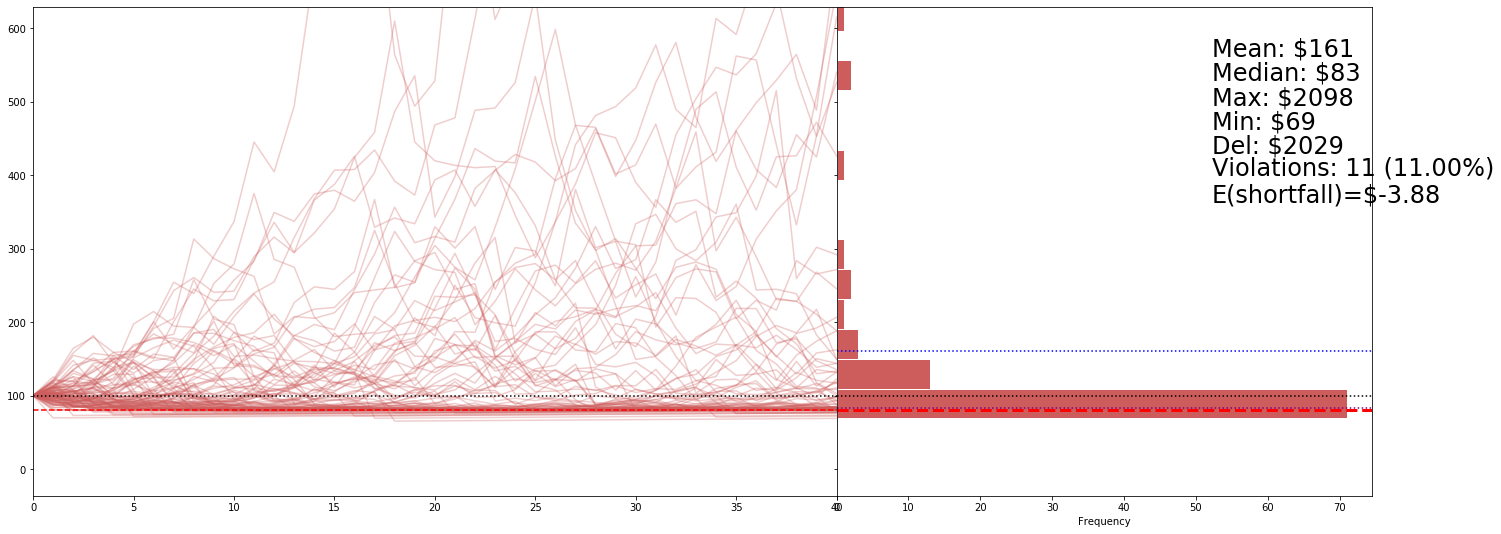

In [0]:
cppi_controls = rk.show_cppi(n_scenarios=100, mu=0.07, sigma=0.35, m=3, floor=0.8, riskfree_rate=0.03, steps_per_year=4, y_max=30)
display(cppi_controls)

**Analysis**

In the three scenarios:
+ Under moderate volatility (15%), even just four anuual rebalances are sufficient to prevent any shortfalls
+ As volatility increases to 35%, maintaining just four annual rebalances are insufficient to prevent threshold violations. When they do occur, a mean shortfall of \$5.34 is seen.
+ Under high volatility conditions, to mitigate shortfalls, monthly rebalances reduce threshold violations by 75%. When they do occur, a mean shortfall of \$1.77 is seen -- which is a reduction of 67%.


**Conclusion**

Under average (15%) volatility conditions, portfolio rebalances as infrequent as once a quarter were found to be sufficient to prevent any violations. However, when volatility increased to extreme levels (35%), more frequent rebalances were necessary to prevent any floor violations. When violations did occur, more frequent rebalances were instrumental in reducing the expected shortfall by 75%.

---

# Asset Liability Management

### Introduction to Asset Management

Between December 1999 and May 2003, pension funds went from a net surplus of 239 billion dollars to a net deficit of 252 billion dollars. A decade later, in the 2008-2009 crisis, forty three states had their pension funds underfunded by more than 10%. If future obligations are fully funded at the present, the best way to ensure that they will remain fully funded is to build a portfolio of immunized bonds that are designed to match the future liability cash flows. In practice, other than in cases where 100% funding ratios are mandated by law, neither pension funds nor personal accounts have the assets to fund all future liabilities. So, the far more common situation is that current assets are not enough to fully fund the future liabilities. Thus, a need arises to allocate the wealth in two portions:
+ Performance Seeking Component Portfolio (PSP): In the PSP, some risks are consciously taken to ensure that the extra risk is well rewarded. So, this component seeks a high Sharpe Ratio portfolio. The PSP construction can be done by starting simply with GBM and then adding complexities.
+ Goal Hedging Portfolio (GHP): For protection in case the worst case where the PSP is unable to deliver the hoped for returns, GHP acts as the immunized bond portfolio. The GHP construction can be started with CIR modeling and then identifying an optimal risk allocation budget. 



### Liability Benchmark

In asset management, as the interest rates effect the valuation of both assets and liabilities, the most important considerations are the funding ratio and surplus:

$$Funding Ratio = \frac{Assets }{Liability}$$ 

$$ Surplus = Assets - Liabilities $$

For simplicity, initially the yield curve is assumed flat. So, the interest rate is the same for all horizons. The present value of a set of liabilities $L$ where each liability $L_i$ is due at time $t_i$ is give by:

$$ PV(L) = \sum_{i=1}^{k} B(t_i) L_i$$

where $B(t_i)$ is the price of a pure discount bond that pays 1 dollar at time $t_i$. If we assume the yield curve is flat and the annual rate of interest is $r$ then $B(t)$ is given by

$$B(t) = \frac{1}{(1+r)^t}$$


While cash may be considered a safe asset, just holding it in a period of falling interest rates can cause a drop in funding ratio. In the illustration below:
+ When interest rate is 9%, the funding ratio is 100.1%
+ When interest rate drops to 7%, the funding ratio drops to 93%

In [0]:
# Effect of interest rates on funding ratio with constant assets and liabilities

liabilities = pd.Series(data=[1, 1.5, 2, 2.5], index=[3, 3.5, 4, 4.5])

def discount(t, r):
    return (1+r)**(-t)

def pv(l, r):
    dates = l.index
    discounts = discount(dates, r)
    return (discounts*l).sum()

def funding_ratio(assets, liabilities, r):
    return assets/pv(liabilities, r)

def show_funding_ratio(assets, r):
    fr = funding_ratio(assets, liabilities, r)
    print("Funding Ratio: " f'{fr*100:.2f}%')
    
controls = widgets.interactive(show_funding_ratio,
                                   assets=widgets.IntSlider(min=1, max=10, step=1, value=5),
                                   r=(0, .20, .01)
)
display(controls)

interactive(children=(IntSlider(value=5, description='assets', max=10, min=1), FloatSlider(value=0.1, descript…

### Simulating Interest Rate Changes

**Cox Ingersoll Ross Model**

While Geometric Brownian Motion is used to model stock price behavior, the Cox Ingersoll Ross (CIR) model is used to model interest rates. This model exhibits mean reverting behavior with model features controlling the long term average and the speed of mean reversion. 

$$ dr_{t}=a(b-r_{t})\,dt+\sigma {\sqrt  {r_{t}}}\,dW_{t} $$

where $a$ is the speed of mean reversion and $b$ is the long term mean rate and $\sigma$ is the volatility parameter. Eliminating the ${\sqrt  {r_{t}}}$ term will enable replication of the simpler Vasicek model, but the CIR model eliminates the possibility of negative interest rates by shutting down the volatility term as interest rates approach zero. 


**Random price evolution of a Zero Coupon Bonds**

A Zero Coupon Bond (ZCB) does not pay any interest bearing coupons but only pays the face value at maturity. Consequently, the present value of the ZCB is a discount value to its maturity value. A ZCB can be modeled as:

$$P(t,T)=A(t,T)e^{-B(t,T)r_{t}}\!$$

where

$$ A(t,T)=\left({\frac  {2h e^{(a+h)\tau/2}}{2h+(a+h)(e^{\tau h}-1)}}\right)^{{2ab/\sigma ^{2}}} $$
and
$$ B(t,T)={\frac  {2(e^{\tau h}-1)}{2h+(a+h)(e^{\tau h}-1)}} $$
and
$$ h={\sqrt  {a^{2}+2\sigma ^{2}}} $$
and
$$ \tau = T-t $$

**Terminal Funding Ratios**

Carrying out a CIR model simulation demonstrates that changes in interest rates can cause a cash-only portfolio to have a dispersion in funding ratio both during that lifespan of the simulation and at termination. While there are clearly cases where the terminal funding ratio is above 1, there are a large number of sub-1 terminal funding ratios. On the other hand, using a ZCB ensures that the terminal funding ratio is always 1.

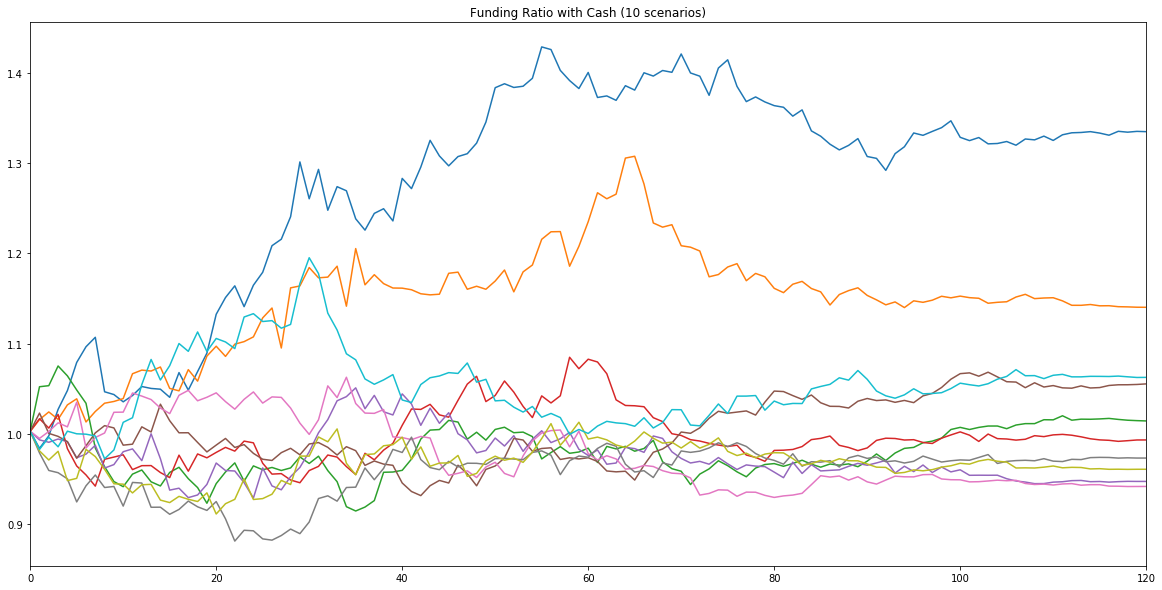

In [0]:
# Paying for $1 liabilities in 10 years

# # my starting asset value today aka cash in hand
# a_0 = 0.75
# # simulate the next 10 years
# rates, bond_prices = rk.cir(r_0=0.03, b=0.03, n_scenarios=10)
# # liabilities are going to change over time to match the payoff of the ZCB
# liabilities = bond_prices
# # today's zero coupon bond price is the present value of 1 dollar in 10 years
# zc_0 = rk.pv(pd.Series(data=[1], index=[10]), 0.03)
# # I can put my money in a zero coupon bond at today's price
# n_bonds = a_0/zc_0
# # and my asset value will grow based on the bond prices
# av_zc_bonds = n_bonds*bond_prices
# # how about if I invest in cash? It will grow at some rate of interest
# av_cash = a_0*(rates/12+1).cumprod()

# a_0, zc_0, n_bonds

# my starting asset value today aka cash in hand
a_0 = 0.75
# simulate the next 10 years
rates, bond_prices = rk.cir(r_0=0.03, b=0.03, n_scenarios=10)
# liabilities are going to change over time to match the payoff of the ZCB
liabilities = bond_prices
# today's zero coupon bond price is the present value of 1 dollar in 10 years
zc_0 = rk.pv(pd.Series(data=[1], index=[10]), 0.03)
# I can put my money in a zero coupon bond at today's price
n_bonds = (a_0/zc_0)
# and my asset value will grow based on the bond prices
av_zc_bonds = n_bonds*bond_prices
# how about if I invest in cash? It will grow at some rate of interest
av_cash = a_0*(rates/12+1).cumprod()

# Using Cash: Changes in asset value, returns over time, and funding ratio over time
#av_cash.plot(title='Asset Values using Cash (10 scenarios)', legend=False, figsize=(12,5))
#av_cash.pct_change().plot(title='Returns using Cash (10 scenarios)', legend=False, figsize=(12,10))
#(av_cash/liabilities).pct_change().plot(title='Returns of Funding Ratio with Cash (10 scenarios)', legend=False, figsize=(12,5))
(av_cash/liabilities).plot(title='Funding Ratio with Cash (10 scenarios)', legend=False, figsize=(20,10))

In [0]:
# Using Zero Coupon Bonds: Changes in asset value, returns over time, and funding ratio over time

# av_zc_bonds.plot(title='Asset Values using ZC Bonds (10 scenarios)', legend=False, figsize=(12,5))
# av_zc_bonds.pct_change().plot(title='Returns using ZC Bonds (10 scenarios)', legend=False, figsize=(12,5))
# (av_zc_bonds/liabilities).pct_change().plot(title='Returns of Funding Ratio with ZC Bonds (10 scenarios)', legend=False, figsize=(12,5))
#(av_zc_bonds/liabilities).plot(title='Funding Ratio with ZC Bonds (10 scenarios)', legend=False, figsize=(20,10))

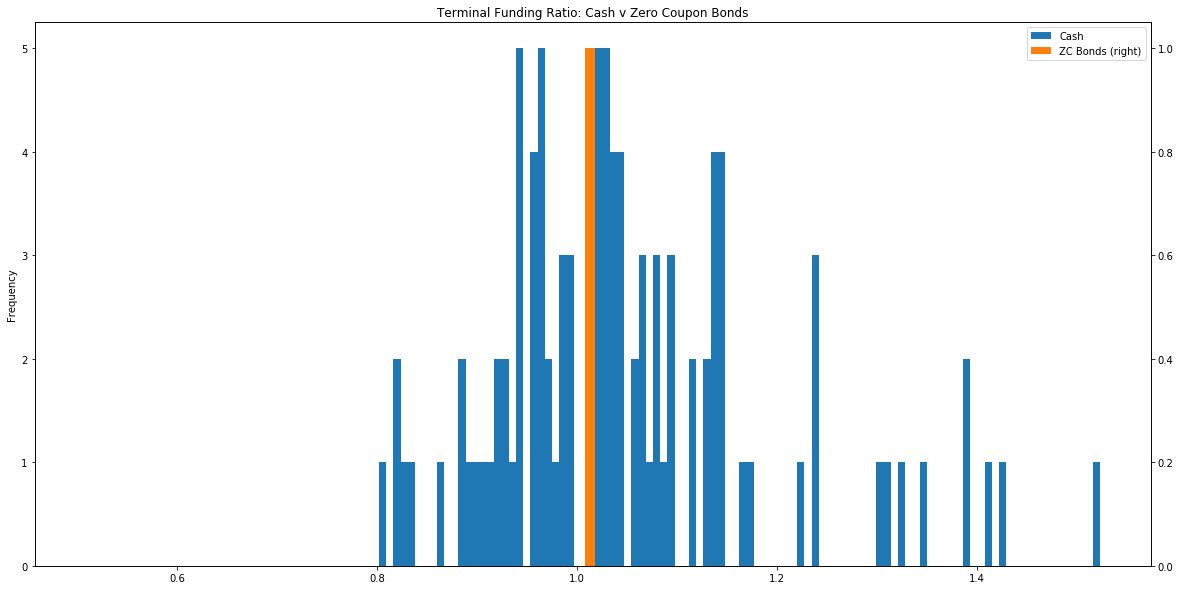

In [0]:
# Computing Terminal funding ratio: Cash vs. Zero Coupon Bond

a_0 = 0.75
rates, bond_prices = rk.cir(r_0=0.03, b=0.03, n_scenarios=100)
liabilities = bond_prices
zc_0 = rk.pv(pd.Series(data=[1], index=[10]), 0.03)
n_bonds = a_0/zc_0
av_zc_bonds = n_bonds*bond_prices
av_cash = a_0*(rates/12+1).cumprod()

tfr_cash = av_cash.iloc[-1]/liabilities.iloc[-1]
tfr_zc_bonds = av_zc_bonds.iloc[-1]/liabilities.iloc[-1]
ax = tfr_cash.plot.hist(label="Cash", figsize=(20,10), bins=100, legend=True)
tfr_zc_bonds.plot.hist(ax=ax,label="ZC Bonds", bins=100, secondary_y=True, legend=True, title ="Terminal Funding Ratio: Cash v Zero Coupon Bonds")

**Conclusion**

To fund a liability driven portfolio, cash can be extremely risky and a ZCB offers a safe choice. However, two simplifying assumptions were made:
+ A ZCB with the perfect maturity is available
+ Initial assets are sufficient to afford the liabilities

In reality, bonds invariably have coupons, so, in the next section, a portfolio of coupon paying bonds will be constructed so that they can replicate the characteristics of a ZCB. Also, a performance seeking portfolio will be added to reduce the initial asset requirement.

### Replicating a ZCB portfolio

As a ZCB is unlikely to be available for the desired maturity, bonds with maturities of 5 to 30 years can be used to replicate the ZCB. Thus, a portfolio that has the same sensitivity to interest rates as the liabilities can effectively provide immunity to interest rate changes.


**Duration Matching**

The duration of a bond measures its senstivity to interest rate changes. Duration matching is the process of ensuring that the duration of the liabilites are matched to the duration of the bond portfolio. For the ZCB, as there is a single cash flow at maturity, the duration is simply the maturity. However, for the portfolio of bonds used to replicate the behavior of ZCB, the average weighted duration needs to be computed.


**Macaulay Duration**

Macaulay Duration which is the weighted average number of periods required to be invested in the bond to get the present value of the bond back. For a two-bond portfolio (short duration, $d_t$ and long duration, $d_l$) with the terminal duration ($d_t$), the weight of the portfolio that needs to be invested in the short duration bond can be computed as:

$$ w_s \times d_s + (1-w_s) \times d_l = d_t $$

$$ w_s = \frac{d_l -d_t}{d_l - d_s} $$

For three liabilities of 100,000, 200,000, and 300,000 dollars maturing in 10, 15, and 20 years. If the discount rate is 5% annually and there are two bonds maturing in 10 and 30 years, then, the duration matching can be carried out as follows: 

In [0]:
l1 = 100000
l2 = 200000
l3 = 300000

t1 = 10
t2 = 15
t3 = 20
discount = 0.05

liabilities = pd.Series(data = [l1, l2, l3], index=[t1, t2, t3])
mdL = rk.macaulay_duration(liabilities, discount)
print("Liabilities Macaulay Duration: ", round(mdL,2), "years")

# Weight of the short bond in the portfolio
short_bond = rk.bond_cash_flows(10, 1000, .05, 1)
long_bond = rk.bond_cash_flows(30, 1000, .05, 1)
w_s = rk.match_durations(liabilities, short_bond, long_bond, 0.04)
print("Weight of the short bond in the portfolio: ", round(w_s*100, 2), "%")

Liabilities Macaulay Duration:  15.95 years
Weight of the short bond in the portfolio:  12.16 %


### Monte Carlo Simulation of Asset Allocation

**Fixed Asset Allocation**

Traditional asset allocation strategies maintain a fixed equity:bond portfolio allocation.  
+ Modeling stocks using GBM: Assuming average annual return and volatility of 7%, 15%
+ Modeling bonds using CIR: Assuming both 10 and 30 year bonds pay 5% coupon payable monthly. With allocation as 60% allocation to 10-year bond and 40% allocation to 30-year bond.
+ Four cases are studied:
    - Volatility as 15% and 35%
    - For each volatility case, equity-bond split is kept at 70-30 and 30-70

In [0]:
# Simulating bond prices: CIR

rates, zc_prices = rk.cir(10, 500, b=0.03, r_0 = 0.03)
price_10 = rk.bond_price(10, 100, .05, 12, rates)
price_30 = rk.bond_price(30, 100, .05, 12, rates)

rets_30 = rk.bond_total_return(price_30, 100, .05, 12)
rets_10 = rk.bond_total_return(price_10, 100, .05, 12)
rets_bonds = .6*rets_10 + .4*rets_30
mean_rets_bonds = rets_bonds.mean(axis='columns')
#rk.summary_stats(pd.DataFrame(mean_rets_bonds))

In [0]:
# Case 1 - Volatility = 15%
# Simulating stock prices: GBM
price_eq1 = rk.gbm(n_years=10,n_scenarios=500,mu=0.07, sigma=0.15)
rets_eq1 = price_eq1.pct_change().dropna()

# Portfolio allocation: 70 - 30
rets1 = .70*rets_eq1 + 0.3*rets_bonds
rets_mean1 = rets1.mean(axis='columns')
p1 = rk.summary_stats(pd.DataFrame(rets_mean1))

# Portfolio allocation: 30 - 70
rets2 = .30*rets_eq1 + 0.7*rets_bonds
rets_mean2 = rets2.mean(axis='columns')
p2 = rk.summary_stats(pd.DataFrame(rets_mean2))

df1 = pd.concat([p1, p2], axis=0)
df1.name = 'Volatility = 15%. (1) 70% Equity, 30% Bonds (2) 30% Equity, 70% Bonds'
print (df1.name)
df1.reset_index(drop=True, inplace=True)
df1

# index = {'70E 30B', '30E 70B'}
# df1 = pd.concat([p1, p2], axis=0)
# df1.reset_index(drop=True, inplace=True)
# df1

# s = pd.Series(['70E 30B', '30E 70B'])
# df1.set_index([s])
# df1

Volatility = 15%. (1) 70% Equity, 30% Bonds (2) 30% Equity, 70% Bonds


,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher Var (5%),Sharpe Ratio,Max Drawdown
0,0.061191,0.004755,-0.469015,3.519389,-0.001573,6.384929,0.0
1,0.046419,0.003297,-0.025492,2.602364,-0.001958,4.846374,0.0


In [0]:
# Case 2 - Volatility = 35%
# Simulating stock prices: GBM
price_eq2 = rk.gbm(n_years=10,n_scenarios=500,mu=0.07, sigma=0.35)
rets_eq2 = price_eq2.pct_change().dropna()

# Portfolio allocation: 70 - 30
rets3 = .70*rets_eq2 + 0.3*rets_bonds
rets_mean3 = rets3.mean(axis='columns')
p3 = rk.summary_stats(pd.DataFrame(rets_mean3))

# Portfolio allocation: 30 - 70
rets4 = .30*rets_eq2 + 0.7*rets_bonds
rets_mean4 = rets4.mean(axis='columns')
p4 = rk.summary_stats(pd.DataFrame(rets_mean4))

df2 = pd.concat([p3, p4], axis=0)
df2.name = 'Volatility = 35%. (1) 70% Equity, 30% Bonds (2) 30% Equity, 70% Bonds'
print (df2.name)
df2.reset_index(drop=True, inplace=True)
df2

Volatility = 35%. (1) 70% Equity, 30% Bonds (2) 30% Equity, 70% Bonds


,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher Var (5%),Sharpe Ratio,Max Drawdown
0,0.054809,0.011306,0.439895,3.607309,0.001683,2.135657,-0.003735
1,0.043729,0.005315,0.491049,3.389891,-0.000852,2.513802,0.000000


**Conclusion**

The above analysis proves that as the portfolio allocation shifts from equity to bonds, a significant improvement is seen in cVaR albeit at the cost of Sharpe Ratio. All the same, under extreme volatility conditions, drawdowns are observed in the 70-30 portfolio.

### Distribution of Terminal Values and Risk Budget Efficiency

Regardless of the investment journey, ultimately, the investors care the most about the terminal value of their investment. As the mean statistics do not capture the distribtion of the returns, spectral analysis is necessary to capture the distribution of the terminal values. To do so, the following characteristics were studied:
+ Mean: Average return of the portfolio
+ Std: Average standard deviation of the portfolio
+ P_Breach: Probability that the returns are below the minimum acceptable return threshold
+ E_Short: Expected shortfall
+ P_Reach: Mean terminal wealth above cap (not valid, as cap has been set to infinity)
+ E_Surplus: Expected Surplus (terminal wealth - cap) (not valid, as cap has been set to infinity)

In [0]:
rates, zc_prices = rk.cir(10, 500, b=0.03, r_0 = 0.03)
price_10 = rk.bond_price(10, 100, .05, 12, rates)
price_30 = rk.bond_price(30, 100, .05, 12, rates)
rets_30 = rk.bond_total_return(price_30, 100, .05, 12)
rets_10 = rk.bond_total_return(price_10, 100, .05, 12)
rets_bonds = rk.bt_mix(rets_10, rets_30, allocator=rk.fixedmix_allocator, w1=.6)

price_eq = rk.gbm(n_years=10,n_scenarios=500,mu=0.07, sigma=0.15)
rets_eq = price_eq.pct_change().dropna()

rets_7030b = rk.bt_mix(rets_eq, rets_bonds, allocator=rk.fixedmix_allocator, w1=0.7)

In [0]:
df = pd.concat([rk.terminal_stats(rets_eq, name="E"),
           rk.terminal_stats(rets_bonds, name="FI"), 
           rk.terminal_stats(rets_7030b, name="70%E+30%FI")],
          axis=1)
df.name = "Distribution of Returns: Equities (E), Fixed Income (FI), Fixed Allocation"
print(df.name)
df

Distribution of Returns: Equities (E), Fixed Income (FI), Fixed Allocation


,E,FI,70%E+30%FI
mean,1.936652,1.398103,1.770877
std,0.887916,0.106486,0.567690
p_breach,0.046000,NaN,0.010000
e_short,0.110778,NaN,0.057985
p_reach,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN


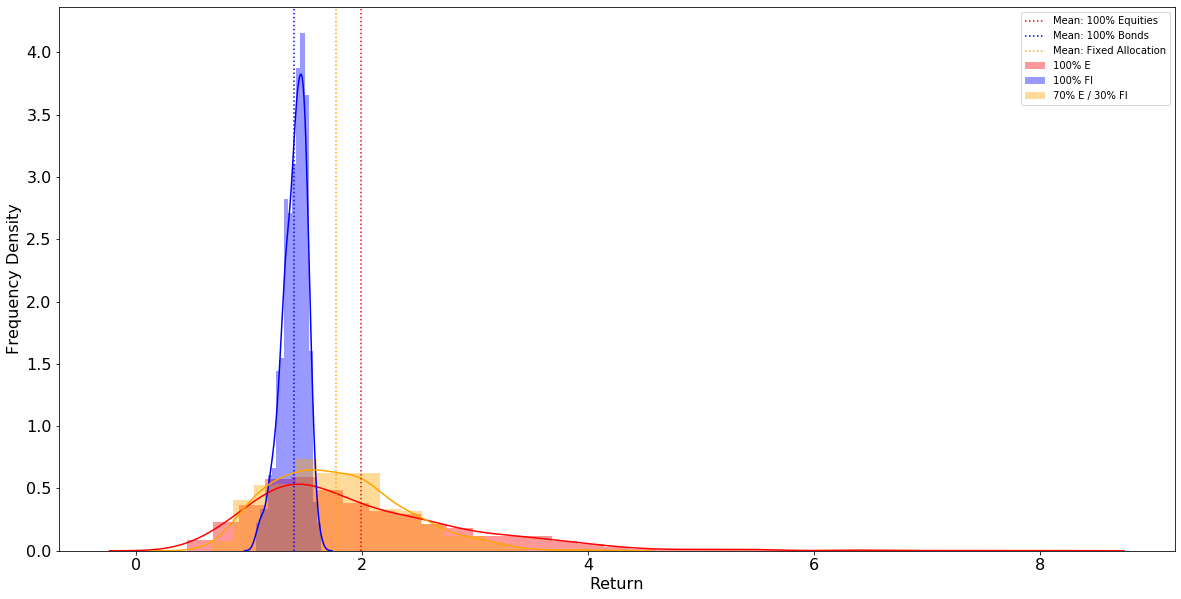

In [0]:
tv_eq = rk.terminal_values(rets_eq)
tv_bonds = rk.terminal_values(rets_bonds)
tv_7030b = rk.terminal_values(rets_7030b)

plt.figure(figsize=(20, 10))
sns.distplot(tv_eq, color="red", label="100% E")
sns.distplot(tv_bonds, color="blue", label="100% FI")
sns.distplot(tv_7030b, color="orange", label="70% E / 30% FI")

plt.axvline(tv_eq.mean(), ls=":", color="red", label = "Mean: 100% Equities")
plt.axvline(tv_bonds.mean(), ls=":", color="blue", label = "Mean: 100% Bonds")
plt.axvline(tv_7030b.mean(), ls=":", color="orange", label = "Mean: Fixed Allocation")

plt.ylabel('Frequency Density', fontsize=16)
plt.xlabel('Return', fontsize=16)
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16) 
plt.legend()

**Conclusion:** The higher mean returns of the equity portfolio is due to the large upside spread of equities. This comes at the risk of a significant shortfall in terminval returns. 

### Glide Path Allocation: Target Date Funds

The underlying assumption behind target date funds is to equate greater maturity date with greater risk holding capacity. So, with greater available time, the risk budget is greater. With less time, the risk budget is smaller. This philosophy was evaluated through a Monte Carlo Simulation over a 10-year period with the portfolio distribution starting with 80% stocks / 20% fixed income and ending with 20% stocks / 80% fixed income at the end of the 10-year period.

In [0]:
rets_8020g = rk.bt_mix(rets_eq, rets_bonds, allocator=rk.glidepath_allocator, start_glide=.8, end_glide=.2)
tv_8020g = rk.terminal_values(rets_8020g)


df = pd.concat([rk.terminal_stats(rets_eq, name="Eq"),
           rk.terminal_stats(rets_bonds, name="FI"), 
           rk.terminal_stats(rets_7030b, name="70E/30FI"),
           rk.terminal_stats(rets_8020g, name="80E to 20E")],
          axis=1)
df.name = "Distribution of Returns: Equities (E), Fixed Income (FI), Fixed Allocation, Target Date Funds"
print(df.name)
df

Distribution of Returns: Equities (E), Fixed Income (FI), Fixed Allocation, Target Date Funds


,Eq,FI,70E/30FI,80E to 20E
mean,1.936652,1.398103,1.770877,1.661393
std,0.887916,0.106486,0.567690,0.427231
p_breach,0.046000,NaN,0.010000,0.004000
e_short,0.110778,NaN,0.057985,0.050121
p_reach,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN


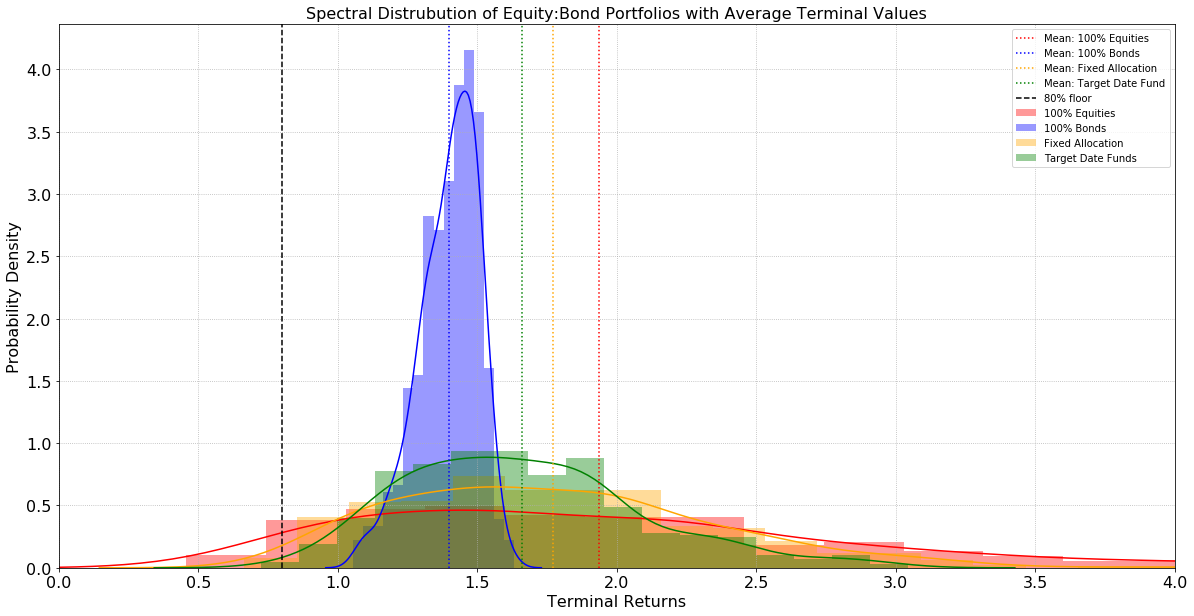

In [0]:
plt.figure(figsize=(20, 10))
sns.distplot(tv_eq, color="red", label="100% Equities")
sns.distplot(tv_bonds, color="blue", label="100% Bonds")
sns.distplot(tv_7030b, color="orange", label="Fixed Allocation")
sns.distplot(tv_8020g, color="green", label="Target Date Funds")
plt.axvline(tv_eq.mean(), ls=":", color="red", label = "Mean: 100% Equities")
plt.axvline(tv_bonds.mean(), ls=":", color="blue", label = "Mean: 100% Bonds")
plt.axvline(tv_7030b.mean(), ls=":", color="orange", label = "Mean: Fixed Allocation")
plt.axvline(tv_8020g.mean(), ls=":", color="green", label = "Mean: Target Date Fund")
plt.axvline(0.8, ls="--", color="black", label = "80% floor")

plt.title("Terminal Value Distribution", fontsize = 16)
plt.ylabel('Frequency Density', fontsize=16)
plt.xlabel('Return', fontsize=16)
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16) 
plt.title("Spectral Distrubution of Equity:Bond Portfolios with Average Terminal Values", fontsize = 16)
plt.xlabel('Terminal Returns')
plt.ylabel('Probability Density')
plt.grid(True, linestyle = ":")
plt.xlim((0,4))
plt.legend()

**Conclusion:** Static or naive risk budgeting involves allocating between the PSP and GHP using either a simple fixed mix or a blind glidepath. These can reduce the downside risk but come at the cost the expected return, and cannot be used to secure a minimum acceptable level of wealth or liabilities. 

---

# Dynamic Risk Hedging

### Floor allocator
Both the fixed allocation and naive target date funds reduce downside risk but also the expected returns. However, similar to the behavior of CPPI strategies, use of a dynamic risk allocator can increase risk budget when there is a cushion. When a cushion is available, a multiple (m = 1 being most conservative to 10 being most aggressive) can be allocated to the risk budget. The following analysis assumed:
+ Volatility = 15%
+ Floor = 20%
+ Scenarios = 1000
+ Risk free rate = 3%
+ Mean return on equity = 7%

The parameter that was analyzed was the multiplier
+ Muliplier (m = 1, 3, 5, 10)

In [0]:
n_scenarios =  1000
rates, zc_prices = rk.cir(10, n_scenarios=n_scenarios, b=0.03, r_0 = 0.03, sigma=0.02)
price_eq = rk.gbm(n_years=10,n_scenarios=n_scenarios, mu=0.07, sigma=0.15)
rets_eq = price_eq.pct_change().dropna()
rets_zc = zc_prices.pct_change().dropna()
tv_zc = rk.terminal_values(rets_zc)


rets_floor80 = rk.bt_mix(rets_eq, rets_zc, allocator=rk.floor_allocator, zc_prices=zc_prices[1:], floor=.80)
rets_floor80m1 = rk.bt_mix(rets_eq, rets_zc, allocator=rk.floor_allocator, zc_prices=zc_prices[1:], floor=.80, m=1)
rets_floor80m3 = rk.bt_mix(rets_eq, rets_zc, allocator=rk.floor_allocator, zc_prices=zc_prices[1:], floor=.80, m=3)
rets_floor80m5 = rk.bt_mix(rets_eq, rets_zc, allocator=rk.floor_allocator, zc_prices=zc_prices[1:], floor=.80, m=5)
rets_floor80m10 = rk.bt_mix(rets_eq, rets_zc, allocator=rk.floor_allocator, zc_prices=zc_prices[1:], floor=.80, m=10)

tv_floor80 = rk.terminal_values(rets_floor80)
tv_floor80m1 = rk.terminal_values(rets_floor80m1)
tv_floor80m3 = rk.terminal_values(rets_floor80m3)
tv_floor80m5 = rk.terminal_values(rets_floor80m5)
tv_floor80m10 = rk.terminal_values(rets_floor80m10)

pd.concat([rk.terminal_stats(rets_eq, name="Equities", floor=0.80),
           rk.terminal_stats(rets_zc, name="Bonds", floor=0.80), 
           rk.terminal_stats(rets_7030b, name="70/30", floor=0.80),
           rk.terminal_stats(rets_floor80, name="Floor80", floor=0.80),
           rk.terminal_stats(rets_floor80m1, name="Floor80m1", floor=0.80),
           rk.terminal_stats(rets_floor80m3, name="Floor80m3", floor=0.80),
           rk.terminal_stats(rets_floor80m5, name="Floor80m5", floor=0.80),
           rk.terminal_stats(rets_floor80m10, name="Floor80m10", floor=0.80)
          ],
          axis=1).round(2)

,Equities,Bonds,70/30,Floor80,Floor80m1,Floor80m3,Floor80m5,Floor80m10
mean,1.99,1.34,1.77,1.95,1.61,1.95,1.97,1.96
std,0.98,0.00,0.57,0.99,0.40,0.99,1.00,1.00
p_breach,0.04,NaN,0.01,NaN,NaN,NaN,NaN,0.04
e_short,0.14,NaN,0.06,NaN,NaN,NaN,NaN,0.00
p_reach,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


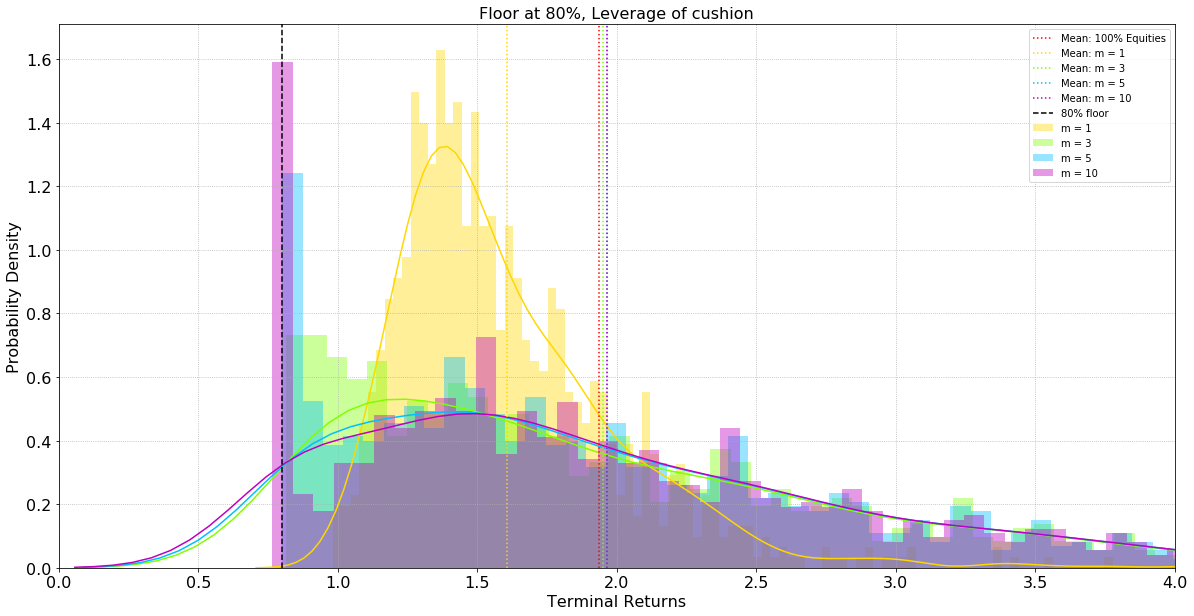

In [0]:
plt.figure(figsize=(20, 10))
sns.distplot(tv_floor80m1, color="gold", label="m = 1", bins=100)
sns.distplot(tv_floor80m3, color="chartreuse", label="m = 3", bins=100)
sns.distplot(tv_floor80m5, color="deepskyblue", label="m = 5", bins=100)
sns.distplot(tv_floor80m10, color="m", label="m = 10", bins=100)

#plt.axvline(rk.terminal_values(rets_floor80).mean(), ls=":", color="sandybrown", label = "Mean: Bonds")
plt.axvline(tv_eq.mean(), ls=":", color="red", label = "Mean: 100% Equities")
plt.axvline(tv_floor80m1.mean(), ls=":", color="gold", label = "Mean: m = 1")
plt.axvline(tv_floor80m3.mean(), ls=":", color="chartreuse", label = "Mean: m = 3")
plt.axvline(tv_floor80m5.mean(), ls=":", color="deepskyblue", label = "Mean: m = 5")
plt.axvline(tv_floor80m10.mean(), ls=":", color="m", label = "Mean: m = 10")
plt.axvline(0.8, ls="--", color="black", label = "80% floor")


plt.title("Floor at 80%, Leverage of cushion", fontsize = 16)
plt.xlabel('Terminal Returns', fontsize = 16)
plt.ylabel('Probability Density', fontsize = 16)
plt.grid(True, linestyle = ":")
plt.xlim((0,4))
plt.legend()

**Conclusion:**

Use of CPPI based techniques to dynamically allocate risk buget:
+ Using a cushion multiplier of 3 or 5 enables returns that are nearly as good as equities while eliminating downside risk.
+ If a cushion multiplier of 1 is too conservative and while it also ensures no floor breaches, there is a significant loss of upside.
+ A cushion multiplier of 10 is too aggressive and while it leads to a marginal performance improvement over m = 3 or 5, there are significant cases close to the floor with some minor breaches as well.


### Drawdown Allocator
Instead of a fixed floor, the drawdown allocator uses the current peak to determine allocation between risky and risk free assets. 

In [0]:
cashrate = 0.02
monthly_cashreturn = (1+cashrate)**(1/12) - 1
rets_cash = pd.DataFrame(data= monthly_cashreturn, index=rets_eq.index, columns=rets_eq.columns)
rets_maxdd20 = rk.bt_mix(rets_eq, rets_cash, allocator=rk.drawdown_allocator, maxdd=.20)
tv_maxdd20 = rk.terminal_values(rets_maxdd20)


pd.concat([rk.terminal_stats(rets_eq, name="Equities", floor=0.80),
           rk.terminal_stats(rets_7030b, name="70/30", floor=0.80),
           rk.terminal_stats(rets_floor80, name="Floor80", floor=0.80),
           rk.terminal_stats(rets_floor80m1, name="Floor80m1", floor=0.80),
           rk.terminal_stats(rets_floor80m3, name="Floor80m3", floor=0.80),
           rk.terminal_stats(rets_floor80m5, name="Floor80m5", floor=0.80),
           rk.terminal_stats(rets_floor80m10, name="Floor80m10", floor=0.80),
           rk.terminal_stats(rets_maxdd20, name="MaxDD20", floor=0.80)           
          ],
          axis=1).round(2)

,Equities,70/30,Floor80,Floor80m1,Floor80m3,Floor80m5,Floor80m10,MaxDD20
mean,1.99,1.77,1.95,1.61,1.95,1.97,1.96,1.55
std,0.98,0.57,0.99,0.40,0.99,1.00,1.00,0.40
p_breach,0.04,0.01,NaN,NaN,NaN,NaN,0.04,NaN
e_short,0.14,0.06,NaN,NaN,NaN,NaN,0.00,NaN
p_reach,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


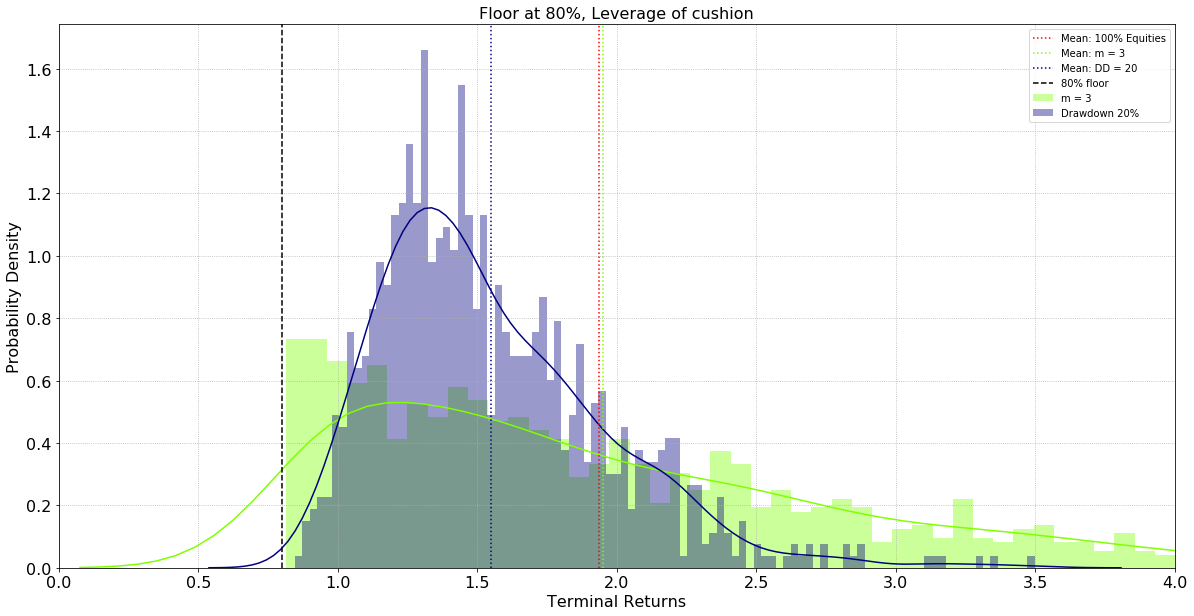

In [0]:
plt.figure(figsize=(20, 10))
#sns.distplot(tv_floor80m1, color="gold", label="m = 1", bins=100)
sns.distplot(tv_floor80m3, color="chartreuse", label="m = 3", bins=100)
#sns.distplot(tv_floor80m5, color="deepskyblue", label="m = 5", bins=100)
#sns.distplot(tv_floor80m10, color="m", label="m = 10", bins=100)
sns.distplot(tv_maxdd20, color="navy", label="Drawdown 20%", bins=100)


#plt.axvline(rk.terminal_values(rets_floor80).mean(), ls=":", color="sandybrown", label = "Mean: Bonds")
plt.axvline(tv_eq.mean(), ls=":", color="red", label = "Mean: 100% Equities")
#plt.axvline(tv_floor80m1.mean(), ls=":", color="gold", label = "Mean: m = 1")
plt.axvline(tv_floor80m3.mean(), ls=":", color="chartreuse", label = "Mean: m = 3")
#plt.axvline(tv_floor80m5.mean(), ls=":", color="deepskyblue", label = "Mean: m = 5")
#plt.axvline(tv_floor80m10.mean(), ls=":", color="m", label = "Mean: m = 10")
plt.axvline(tv_maxdd20.mean(), ls=":", color="navy", label = "Mean: DD = 20")
plt.axvline(0.8, ls="--", color="black", label = "80% floor")


plt.title("Floor at 80%, Leverage of cushion", fontsize = 16)
plt.xlabel('Terminal Returns', fontsize = 16)
plt.ylabel('Probability Density', fontsize = 16)
plt.grid(True, linestyle = ":")
plt.xlim((0,4))
plt.legend()

**Conclusion:** Contrary to initial expectation, use of a max drawdown strategy leads to a significant reduction in standard deviation but it comes at a massive cost of giving up on the upside gains.

### Comparison of Maximum Drawdown

In [0]:
# Max Drawdown
#maxDD_Cash = rk.summary_stats(rets_cash)["Max Drawdown"].min()
maxDD_Equity = rk.summary_stats(rets_eq)["Max Drawdown"].min()
maxDD_Bonds = rk.summary_stats(rets_zc)["Max Drawdown"].min()
maxDD_7030 = rk.summary_stats(rets_7030b)["Max Drawdown"].min()
maxDD_8020g = rk.summary_stats(rets_8020g)["Max Drawdown"].min()
#rets_floor80
maxDD_floor80 = rk.summary_stats(rets_floor80)["Max Drawdown"].min()
maxDD_floor80m1 = rk.summary_stats(rets_floor80m1)["Max Drawdown"].min()
maxDD_floor80m3 = rk.summary_stats(rets_floor80m3)["Max Drawdown"].min()
maxDD_floor80m5 = rk.summary_stats(rets_floor80m5)["Max Drawdown"].min()
maxDD_floor80m10 = rk.summary_stats(rets_floor80m10)["Max Drawdown"].min()
# Drowdown
maxDD_20 = rk.summary_stats(rets_maxdd20)["Max Drawdown"].min()

# Avg Drawdown
# maxDD_Cash = rk.summary_stats(rets_cash)["Max Drawdown"].min()
avgDD_Equity = rk.summary_stats(rets_eq)["Max Drawdown"].mean()
avgDD_Bonds = rk.summary_stats(rets_zc)["Max Drawdown"].mean()
avgDD_7030 = rk.summary_stats(rets_7030b)["Max Drawdown"].mean()
avgDD_8020g = rk.summary_stats(rets_8020g)["Max Drawdown"].mean()
# rets_floor80
avgDD_floor80 = rk.summary_stats(rets_floor80)["Max Drawdown"].mean()
avgDD_floor80m1 = rk.summary_stats(rets_floor80m1)["Max Drawdown"].mean()
avgDD_floor80m3 = rk.summary_stats(rets_floor80m3)["Max Drawdown"].mean()
avgDD_floor80m5 = rk.summary_stats(rets_floor80m5)["Max Drawdown"].mean()
avgDD_floor80m10 = rk.summary_stats(rets_floor80m10)["Max Drawdown"].mean()
# Drowdown
avgDD_20 = rk.summary_stats(rets_maxdd20)["Max Drawdown"].mean()

In [0]:
# Comparing the drawdowns
data = {"Max Drawdown: Worst":[round(maxDD_Equity*100,2), round(maxDD_Bonds*100,2), round(maxDD_7030*100,2), round(maxDD_8020g*100,2), round(maxDD_floor80*100,2), round(maxDD_floor80m1*100,2), round(maxDD_floor80m3*100,2), round(maxDD_floor80m5*100,2), round(maxDD_floor80m10*100,2), round(maxDD_20*100,2)], "Max Drawdown: Avg":[round(avgDD_Equity*100,2), round(avgDD_Bonds*100,2), round(avgDD_7030*100,2), round(avgDD_8020g*100,2), round(avgDD_floor80*100,2), round(avgDD_floor80m1*100,2), round(avgDD_floor80m3*100,2), round(avgDD_floor80m5*100,2), round(avgDD_floor80m10*100,2), round(avgDD_20*100,2)]}
df = pd.DataFrame(data, index =['Equity', 'Bond', 'Fixed Allocation', 'Target Date Fund', "80% floor: ZCB", "80% floor: m=1", "80% floor: m=3", "80% floor: m=5", "80% floor: m=10", "Max DD: 20%"]) 
df

,Max Drawdown: Worst,Max Drawdown: Avg
Equity,-71.33,-29.83
Bond,-7.97,-2.18
Fixed Allocation,-55.24,-21.21
Target Date Fund,-45.08,-17.07
80% floor: ZCB,-56.47,-27.64
80% floor: m=1,-31.84,-11.94
80% floor: m=3,-56.47,-27.64
80% floor: m=5,-59.24,-28.58
80% floor: m=10,-60.80,-28.95
Max DD: 20%,-18.31,-12.36


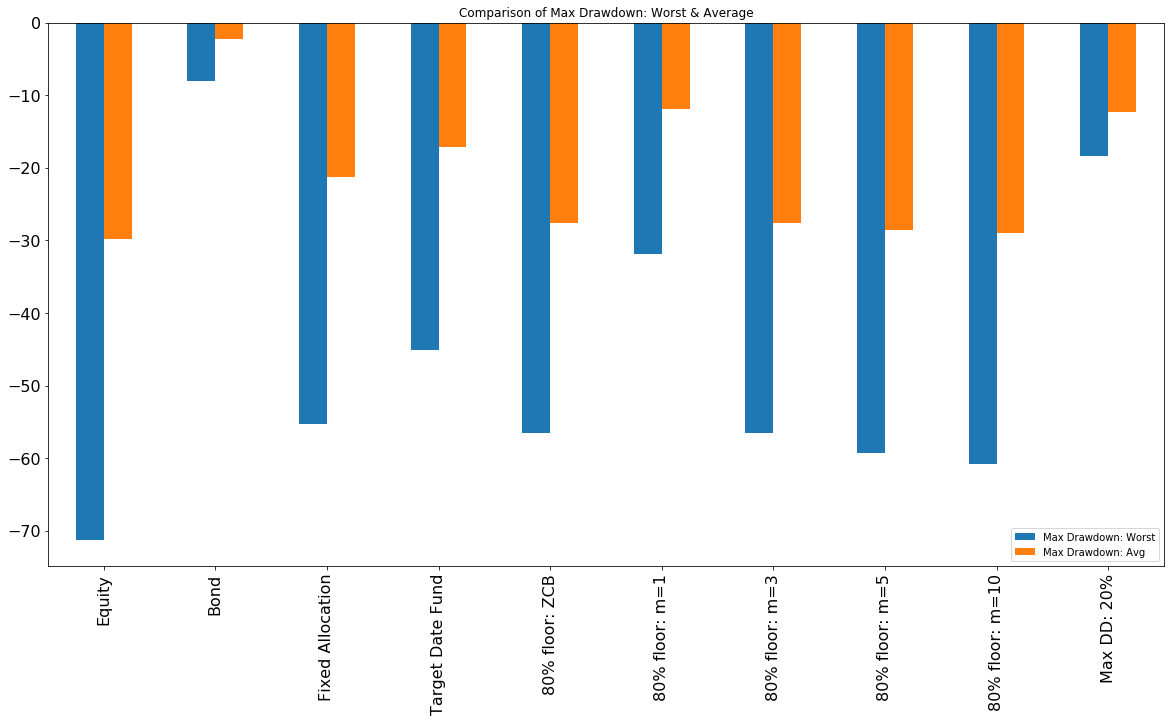

In [0]:
df.plot.bar(figsize=(20,10), legend=True, title = "Comparison of Max Drawdown: Worst & Average", fontsize = 16)#, color = "sandybrown")

**Conclusion:** While the max drawdown strategy did not have terminal returns as good as other CPPI-style leveraged cushion strategies, the strategy ensured that through the duration of the investment, at no point was the investment value below the 80% floor.

### Market OutPerformance: Historical Data Backtest

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher Var (5%),Sharpe Ratio,Max Drawdown
Market,0.073280,0.261505,0.479355,8.700367,0.168423,0.160753,-0.834215
MaxDD,0.067526,0.075601,-0.669854,5.281315,0.047264,0.483019,-0.195536


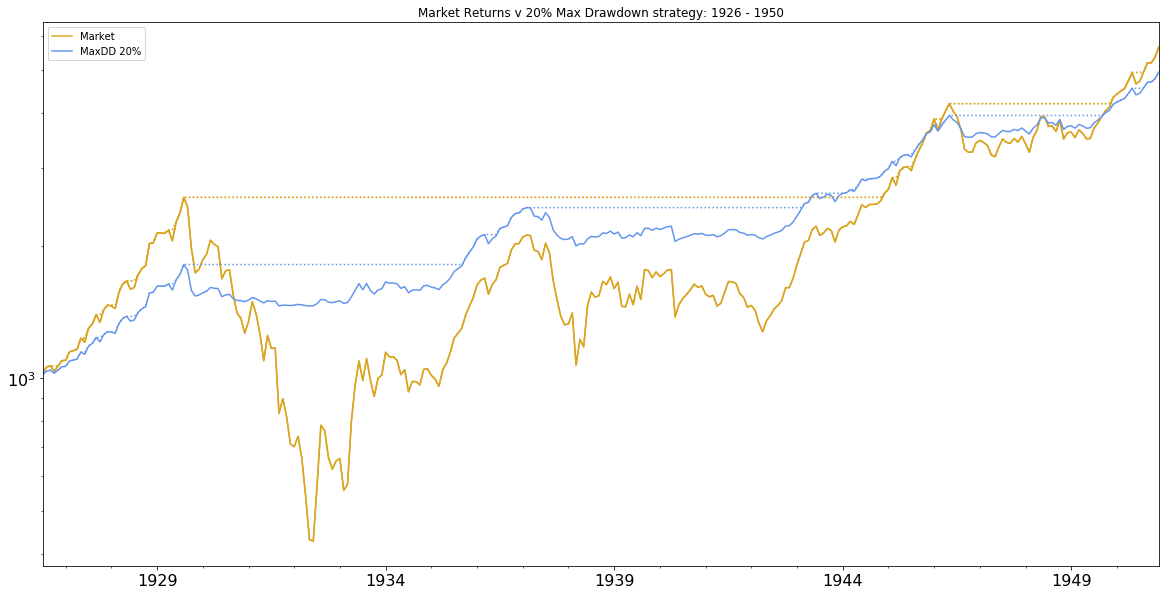

In [0]:
rets_tmi =  rk.get_total_market_index_returns()["1926":"1950"]
dd_tmi = rk.drawdown(rets_tmi)
dd_tmi.head()
ax = dd_tmi["Wealth"].plot(figsize=(20,10), ls="-", color="goldenrod").set_yscale('log')
dd_tmi["Peaks"].plot(ax=ax, ls=":", color="goldenrod")

cashrate = 0.03
monthly_cashreturn = (1+cashrate)**(1/12) - 1
rets_cash = pd.DataFrame(data= monthly_cashreturn, index=rets_tmi.index, columns=[0]) # 1 column dataframe

rets_maxdd20 = rk.bt_mix(pd.DataFrame(rets_tmi), rets_cash, allocator=rk.drawdown_allocator, maxdd=.20, m=3)
dd_20 = rk.drawdown(rets_maxdd20[0])

ax = dd_tmi["Wealth"].plot(figsize=(20,10), ls="-", color="goldenrod", label="Market", legend=True, title = "Market Returns v 20% Max Drawdown strategy: 1926 - 1950")
dd_tmi["Peaks"].plot(ax=ax, ls=":", color="goldenrod")

dd_20["Wealth"].plot(ax=ax, label="MaxDD 20%", color="cornflowerblue", legend=True)
dd_20["Peaks"].plot(ax=ax, color="cornflowerblue", ls=":")


rk.summary_stats(pd.concat([rets_tmi.rename("Market"), rets_maxdd20[0].rename("MaxDD")], axis=1))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher Var (5%),Sharpe Ratio,Max Drawdown
Market,0.105318,0.137129,-0.133471,3.961838,0.078248,0.534431,-0.455379
MaxDD,0.072102,0.065580,-0.342743,2.924948,0.034872,0.624785,-0.164766


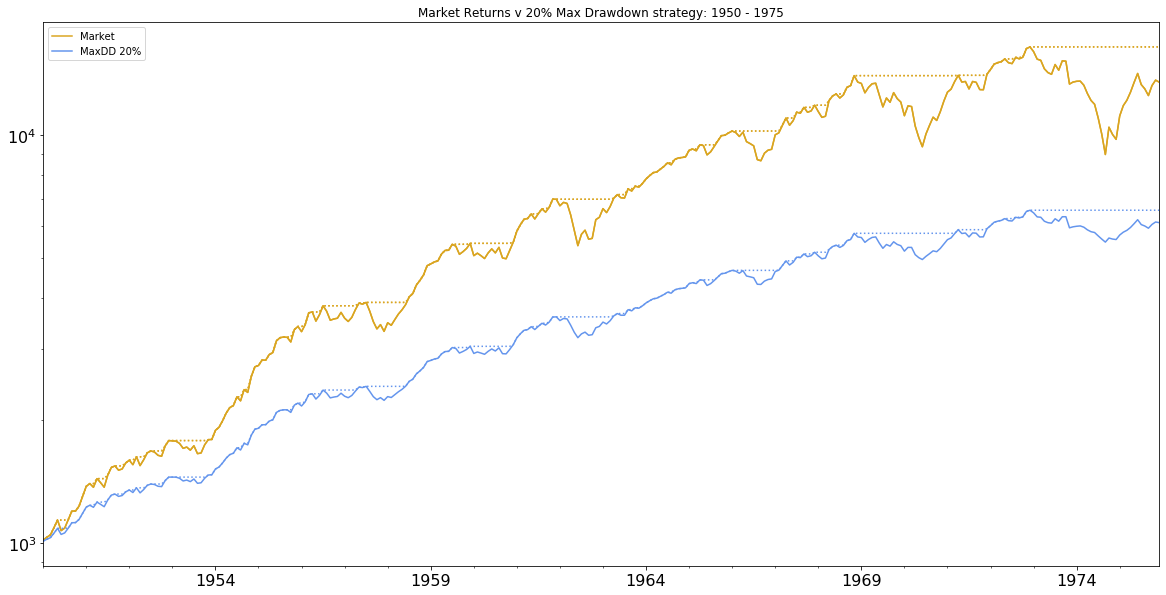

In [0]:
rets_tmi =  rk.get_total_market_index_returns()["1950":"1975"]
dd_tmi = rk.drawdown(rets_tmi)
dd_tmi.head()
ax = dd_tmi["Wealth"].plot(figsize=(20,10), ls="-", color="goldenrod").set_yscale('log')
dd_tmi["Peaks"].plot(ax=ax, ls=":", color="goldenrod")

cashrate = 0.03
monthly_cashreturn = (1+cashrate)**(1/12) - 1
rets_cash = pd.DataFrame(data= monthly_cashreturn, index=rets_tmi.index, columns=[0]) # 1 column dataframe

rets_maxdd20 = rk.bt_mix(pd.DataFrame(rets_tmi), rets_cash, allocator=rk.drawdown_allocator, maxdd=.20, m=3)
dd_20 = rk.drawdown(rets_maxdd20[0])

ax = dd_tmi["Wealth"].plot(figsize=(20,10), ls="-", color="goldenrod", label="Market", legend=True, title = "Market Returns v 20% Max Drawdown strategy: 1950 - 1975")
dd_tmi["Peaks"].plot(ax=ax, ls=":", color="goldenrod")

dd_20["Wealth"].plot(ax=ax, label="MaxDD 20%", color="cornflowerblue", legend=True)
dd_20["Peaks"].plot(ax=ax, color="cornflowerblue", ls=":")


rk.summary_stats(pd.concat([rets_tmi.rename("Market"), rets_maxdd20[0].rename("MaxDD")], axis=1))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher Var (5%),Sharpe Ratio,Max Drawdown
Market,0.164807,0.153690,-0.651882,5.926356,0.090431,0.853589,-0.297608
MaxDD,0.100831,0.084951,-0.740454,6.478784,0.050295,0.811453,-0.149872


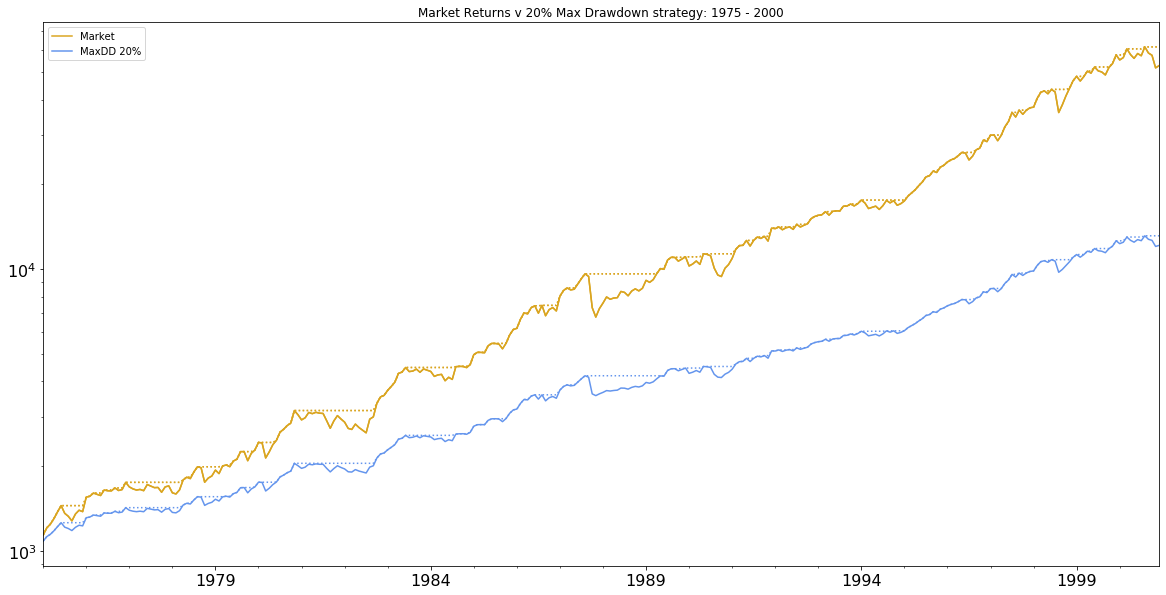

In [0]:
rets_tmi =  rk.get_total_market_index_returns()["1975":"2000"]
dd_tmi = rk.drawdown(rets_tmi)
dd_tmi.head()
ax = dd_tmi["Wealth"].plot(figsize=(20,10), ls="-", color="goldenrod").set_yscale('log')
dd_tmi["Peaks"].plot(ax=ax, ls=":", color="goldenrod")

cashrate = 0.03
monthly_cashreturn = (1+cashrate)**(1/12) - 1
rets_cash = pd.DataFrame(data= monthly_cashreturn, index=rets_tmi.index, columns=[0]) # 1 column dataframe

rets_maxdd20 = rk.bt_mix(pd.DataFrame(rets_tmi), rets_cash, allocator=rk.drawdown_allocator, maxdd=.20, m=3)
dd_20 = rk.drawdown(rets_maxdd20[0])

ax = dd_tmi["Wealth"].plot(figsize=(20,10), ls="-", color="goldenrod", label="Market", legend=True, title = "Market Returns v 20% Max Drawdown strategy: 1975 - 2000")
dd_tmi["Peaks"].plot(ax=ax, ls=":", color="goldenrod")

dd_20["Wealth"].plot(ax=ax, label="MaxDD 20%", color="cornflowerblue", legend=True)
dd_20["Peaks"].plot(ax=ax, color="cornflowerblue", ls=":")


rk.summary_stats(pd.concat([rets_tmi.rename("Market"), rets_maxdd20[0].rename("MaxDD")], axis=1))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher Var (5%),Sharpe Ratio,Max Drawdown
Market,0.054661,0.148958,-0.610054,3.953059,0.096183,0.160939,-0.499943
MaxDD,0.045776,0.063183,-0.578736,3.260849,0.039744,0.242936,-0.174413


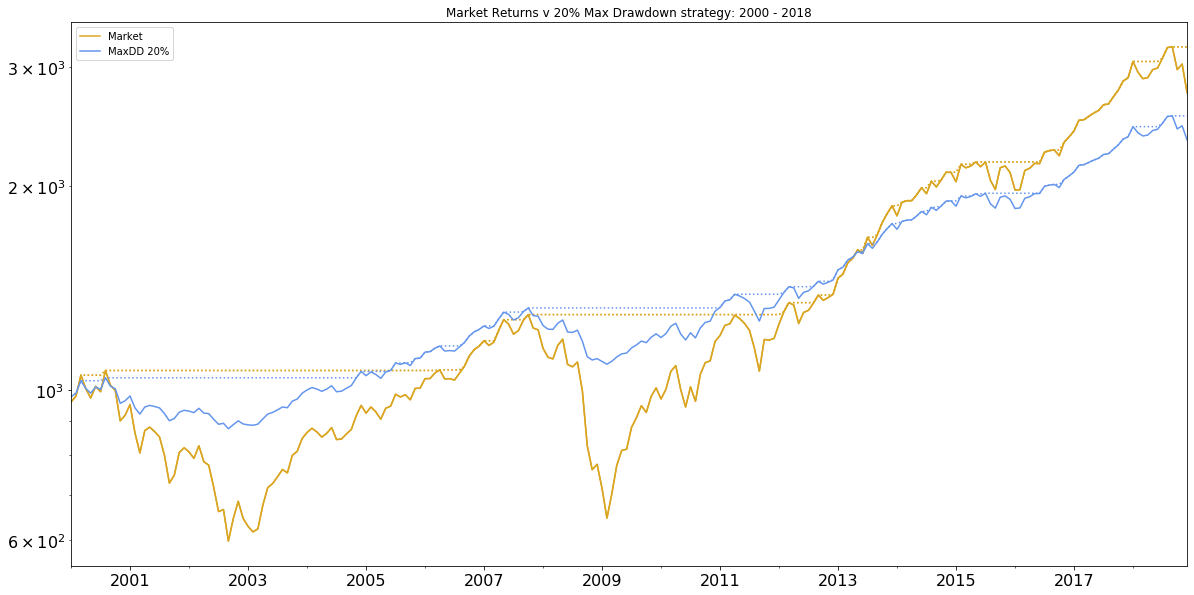

In [0]:
rets_tmi =  rk.get_total_market_index_returns()["2000":]
dd_tmi = rk.drawdown(rets_tmi)
dd_tmi.head()
ax = dd_tmi["Wealth"].plot(figsize=(20,10), ls="-", color="goldenrod").set_yscale('log')
dd_tmi["Peaks"].plot(ax=ax, ls=":", color="goldenrod")

cashrate = 0.03
monthly_cashreturn = (1+cashrate)**(1/12) - 1
rets_cash = pd.DataFrame(data= monthly_cashreturn, index=rets_tmi.index, columns=[0]) # 1 column dataframe

rets_maxdd20 = rk.bt_mix(pd.DataFrame(rets_tmi), rets_cash, allocator=rk.drawdown_allocator, maxdd=.20, m=3)
dd_20 = rk.drawdown(rets_maxdd20[0])

ax = dd_tmi["Wealth"].plot(figsize=(20,10), ls="-", color="goldenrod", label="Market", legend=True, title = "Market Returns v 20% Max Drawdown strategy: 2000 - 2018")
dd_tmi["Peaks"].plot(ax=ax, ls=":", color="goldenrod")

dd_20["Wealth"].plot(ax=ax, label="MaxDD 20%", color="cornflowerblue", legend=True)
dd_20["Peaks"].plot(ax=ax, color="cornflowerblue", ls=":")


rk.summary_stats(pd.concat([rets_tmi.rename("Market"), rets_maxdd20[0].rename("MaxDD")], axis=1))

**Conclusion:** Compared to the market returns, the 20% max drawdown strategy improves sharpe ratio by 50% and reduces the average drawdown by 34% while giving up just 0.9% in annualized return. Over the prior eightteen years, the strategy outperformed the market in fourteen years.